**Important!!!** 

Checks to do:

- initial state given to the KF is similar to the first couple of radar measurements
- ukf.predict(dt = dt) where dt is the varying timestep


In [192]:
import numpy as np
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt

from filterpy.kalman import UnscentedKalmanFilter as UKF
from filterpy.kalman import MerweScaledSigmaPoints
from filterpy.common import Q_discrete_white_noise
# import numpy as np
import math
from numpy.random import randn
from scipy.integrate import solve_ivp
from math import atan2
from tqdm import tqdm



In [301]:
G = 6.67430e-11  # Gravitational constant (m^3 kg^-1 s^-2)
M_EARTH = 5.972e24  # Mass of Earth (kg)
R_EARTH = 6371e3  # Radius of Earth (m)
ATMOSPHERE_HEIGHT = 120e3  # Approximate height of the atmosphere (m)
CD = 2.2  # Drag coefficient (dimensionless)
A = 1.0  # Cross-sectional area of the satellite (m^2)
M_SAT = 500  # Mass of the satellite (kg)
RHO_0 = 1.225  # Air density at sea level (kg/m^3)
H_SCALE = 8500  # Scale height of the atmosphere (m)

In [ ]:
class SatelliteTraj: 
    def __init__(self, pos, vel, vel_std):
        self.pos = np.asarray(pos, dtype=float)
        self.vel = np.asarray(vel, dtype=float)
        self.vel_std = vel_std 
        
    def update(self, dt):
        """Compute next position using RK45 with dynamics inside."""
        def atmospheric_density(altitude):
            if altitude > 0:
                return RHO_0 * np.exp(-altitude / H_SCALE)
            else:
                return 0
    
        def dynamics(t, state):
            x, y, z, vx, vy, vz = state
            r = np.linalg.norm([x,y,z])
            altitude = r - R_EARTH
            # if altitude <= 0:
            #     raise RuntimeError("Satellite has already reentered or impacted the ground.")

            ### Gravity
            a = -G * M_EARTH / r**2

            ### Drag
            rho = atmospheric_density(altitude)
            # v = np.sqrt(vx**2 + vy**2 + vz**2)
            v = np.linalg.norm([vx,vy,vz])
            
            

            F_drag_x = -0.5 * rho * CD * A * v * vx / M_SAT
            F_drag_y = -0.5 * rho * CD * A * v * vy / M_SAT
            F_drag_z = -0.5 * rho * CD * A * v * vz / M_SAT

            # print("alt:", altitude, "'rho:", rho, CD, A, M_SAT, "vels:",  v, vx, vy, vz, "drag:", F_drag_x)

            ax = a * x/r + F_drag_x
            ay = a * y/r + F_drag_y
            az = a * z/r + F_drag_z
            
            return [vx, vy, vz, ax, ay, az]
        
        def stop_condition(t, y):
            # Stop when altitude <= 0
            if t == 0:
                return 1.0  # Don't trigger at initial step
            x,y,z = y[:3]
            r = np.linalg.norm([x,y,z])
            altitude = r - R_EARTH
            return altitude

        stop_condition.terminal = True
        stop_condition.direction = -1
        state0 = np.hstack((self.pos, self.vel)).flatten()

        sol = solve_ivp(dynamics, [0, dt], y0=state0, method='RK45', t_eval=[dt], events=stop_condition, rtol=1e-5, atol=1e-2)
        
        if sol.success and len(sol.y) > 0:
            # print(sol.y, type(sol.y))
            new_state = sol.y.flatten()
            self.pos = new_state[:3]
            self.vel = new_state[3:]

            # # Optionally apply Gaussian noise to velocity
            # if self.vel_std:
            #     self.vel += np.random.normal(0, self.vel_std, size=3)
            return self.pos, self.vel
        
        elif sol.success and len(sol.y)==0:
            # print(sol.y_events, type(sol.y_events))
            new_state = np.array(sol.y_events).flatten()
            self.pos = new_state[:3]
            self.vel = new_state[3:]
            return self.pos, self.vel
        else:
            print("Integration failed!")



In [403]:
sat = SatelliteTraj(pos=[R_EARTH + 400e3, 0., 0.], vel=[-10., 7600., 10.], vel_std=0.0)
num_iterations = 50000
xs = []
for _ in tqdm(range(num_iterations)):
    # print(sat.update(10))  # simulate 10-second intervals
    update_state = sat.update(dt = 10.)
    # print(update_state)
    xs.append(update_state)
    if np.linalg.norm(update_state[0]) - R_EARTH <=0: break

xs = np.array(xs)
xs = xs.reshape(xs.shape[0], -1)

 20%|██        | 10064/50000 [00:16<01:07, 593.18it/s]


In [382]:
100000/3600/24

1.1574074074074074

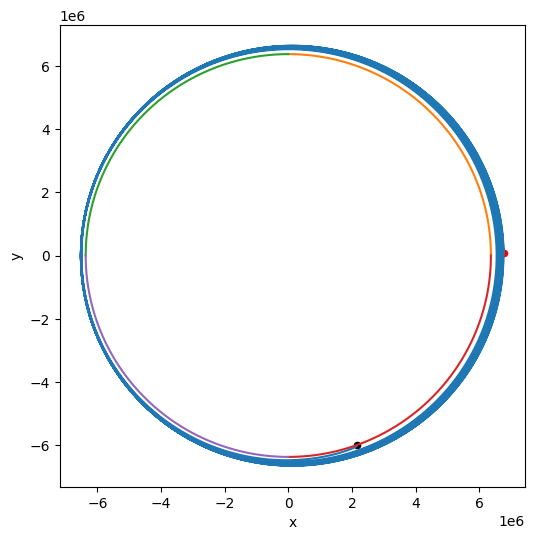

In [404]:
x_axis = np.linspace(0, R_EARTH, 1000)
y_axis = np.sqrt(R_EARTH**2-x_axis**2)
plt.figure(figsize = (6,6))
plt.plot(xs[:, 0] , xs[:, 1], label = '')
plt.plot(x_axis, y_axis)
plt.plot(-x_axis, y_axis)
plt.plot(x_axis, -y_axis)
plt.plot(-x_axis, -y_axis)
plt.scatter(xs[0, 0] , xs[0, 1], label = 'start', color = 'red', s = 20)
plt.scatter(xs[-1, 0] , xs[-1, 1], label = 'end', color = 'black', s = 20)
# plt.xscale('log', base = 10)
# plt.yscale('log', base = 10)
plt.xlabel('x')
plt.ylabel('y')
plt.title('')
# plt.legend()
# plt.grid()
plt.show()

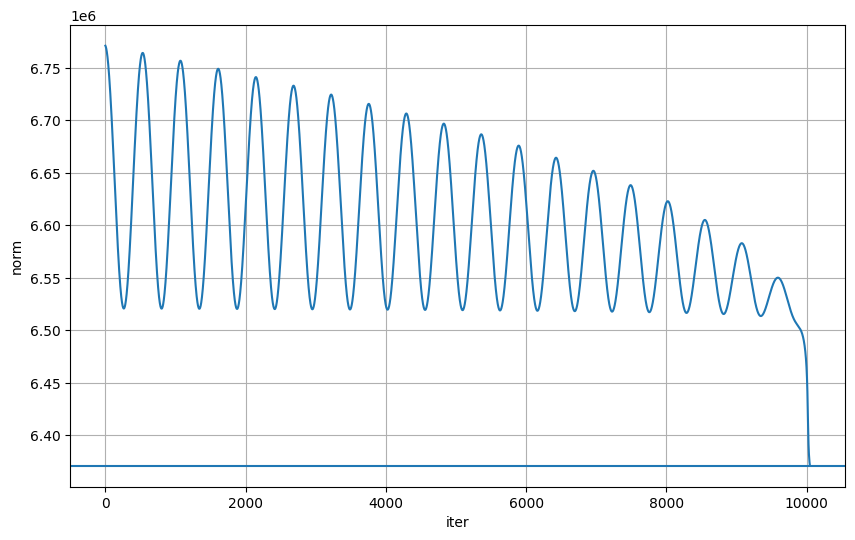

In [401]:
xs_norm = [np.linalg.norm(xs[i]) for i in range(10048)]

plt.figure(figsize = (10,6))
plt.plot(xs_norm)
plt.axhline(y=R_EARTH)
plt.xlabel('iter')
plt.ylabel('norm')
plt.title('')
# plt.legend()
plt.grid()
plt.show()

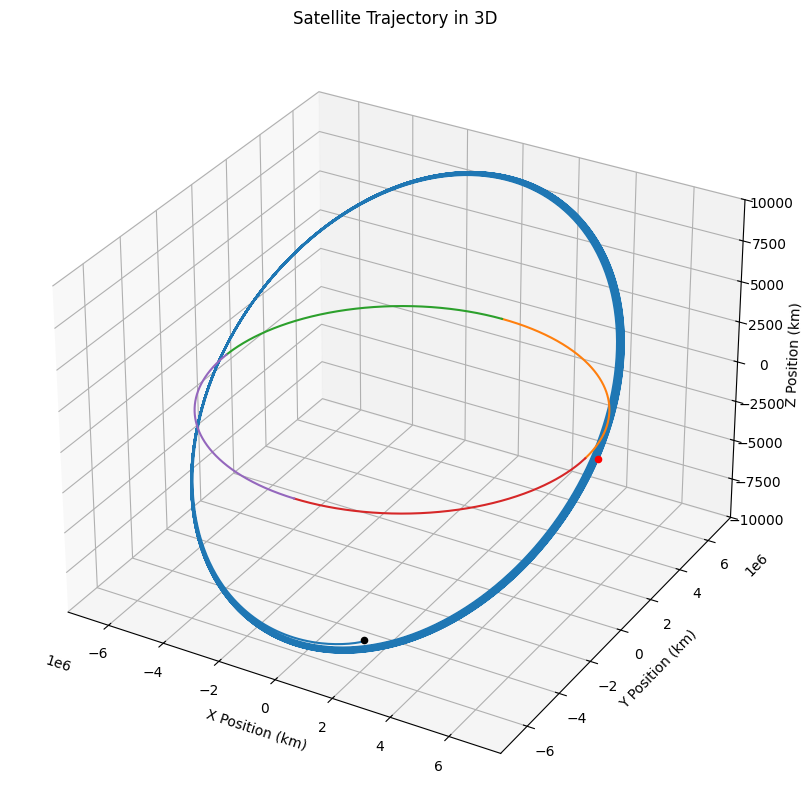

In [405]:
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d')
ax.plot(xs[:, 0] , xs[:, 1], xs[:, 2])
plt.plot(x_axis, y_axis)
plt.plot(-x_axis, y_axis)
plt.plot(x_axis, -y_axis)
plt.plot(-x_axis, -y_axis)
ax.scatter(xs[0, 0] , xs[0, 1], xs[0, 2], label = 'start', color = 'red', s = 20)
ax.scatter(xs[-1, 0] , xs[-1, 1], xs[-1, 2], label = 'end', color = 'black', s = 20)
ax.set_title('Satellite Trajectory in 3D')
ax.set_xlabel('X Position (km)')
ax.set_ylabel('Y Position (km)')
ax.set_zlabel('Z Position (km)')
plt.show()

# Get the radar measurment

In [5]:
def h_radar(x):
    """x is the state vector,
    this H function assumes radar sends positions in global coordinate system"""
    # dx = x[0] - h_radar.radar_pos[0]
    # dy = x[2] - h_radar.radar_pos[1]
    # slant_range = math.sqrt(dx**2 + dy**2)
    # elevation_angle = math.atan2(dy, dx)
    # return [slant_range, elevation_angle]
    return x[:3]  # return x,y,z position

# h_radar.radar_pos = (0, 0)

In [68]:
class RadarStation:
    
    def __init__(self, radar_pos, x_std, y_std, z_std):
        self.radar_pos = np.asarray(radar_pos)       
        self.x_std = x_std
        self.y_std = y_std
        self.z_std = z_std

    
    def reading_of(self, satellite_pos):
    #     """ Returns (range, elevation angle) to aircraft. 
    #     Elevation angle is in radians.
    #     """
        
    #     diff = np.subtract(ac_pos, self.pos)
    #     rng = norm(diff)
    #     brg = atan2(diff[1], diff[0])
        # return rng, brg
        return satellite_pos[0], satellite_pos[1], satellite_pos[2]


    def noisy_reading(self, satellite_pos, time):
        """ Compute range and elevation angle to aircraft with 
        simulated noise"""
        
        x,y,z = self.reading_of(satellite_pos)      
        x += randn() * self.x_std
        y += randn() * self.y_std 
        z += randn() * self.z_std
        return x,y,z, time

In [ ]:
satellite_pos_true = SatelliteTraj(pos=[R_EARTH + 1000e3, 0, 0], vel=[0, 7700, 0], vel_std=0.0001)  # true satellite position with noise
num_iterations = 1000
dt = 10.

radar = RadarStation((0,0,0), 10, 10, 10)

xs = []
zs = []
for iter in range(num_iterations):
    # print(sat.update(10))  # simulate 10-second intervals
    sate_pos = satellite_pos_true.update(dt = dt)
    xs.append(sate_pos)
    z = radar.noisy_reading(satellite_pos= sate_pos, time = (iter+1)*dt)
    zs.append(z)

xs = np.array(xs)
zs = np.array(zs)



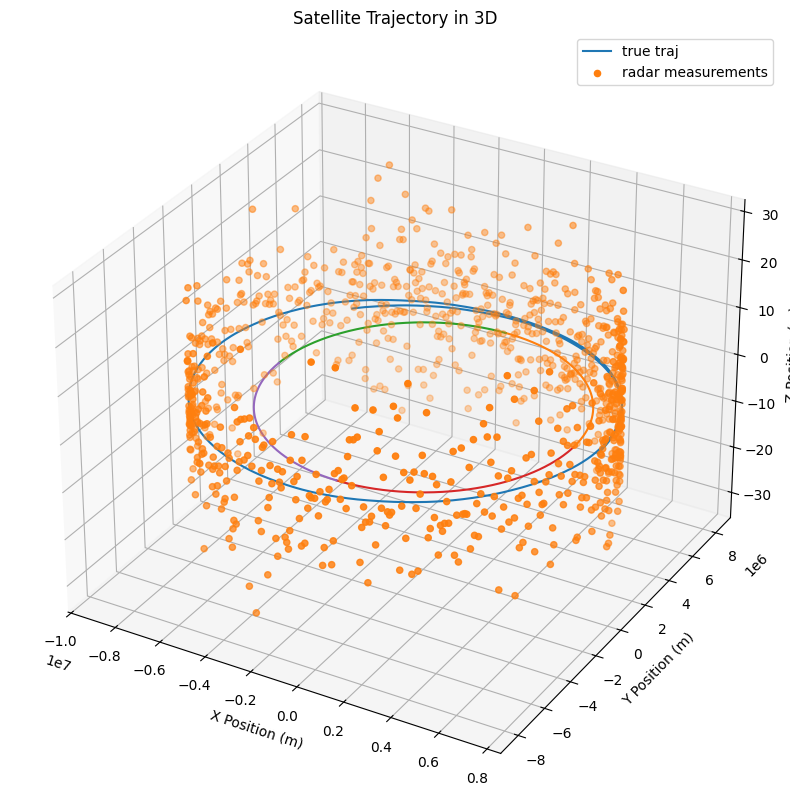

In [138]:
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d')
ax.plot(xs[:, 0] , xs[:, 1], xs[:, 2], label = 'true traj')
ax.scatter(zs[:, 0] , zs[:, 1], zs[:, 2], color = 'C1', label = 'radar measurements')
plt.plot(x_axis, y_axis)
plt.plot(-x_axis, y_axis)
plt.plot(x_axis, -y_axis)
plt.plot(-x_axis, -y_axis)
# ax.set_zlim(-100, 100)
ax.set_title('Satellite Trajectory in 3D')
ax.set_xlabel('X Position (m)')
ax.set_ylabel('Y Position (m)')
ax.set_zlabel('Z Position (m)')
plt.legend()
plt.show()

# Define the process model f

In [155]:
def ode(t, state_x):
        x, y, z, vx, vy, vz= state_x
        r = np.linalg.norm(state_x[:3])
        a = -G * M_EARTH / r**2
        ax = a * x/r
        ay = a * y/r
        az = a * z/r
        return np.array([vx, vy, vz, ax, ay, az])

In [156]:
def f(state_x, dt):

    """state vector = state_x = [x,y,z,vx, vy, vz]"""

    if dt <= 10.:
        x, y, z, vx, vy, vz= state_x
        _, _, _, ax, ay, az = ode(0, state_x)
        # Use Euler's method for small dt
        x_new = x + vx * dt
        y_new = y + vy * dt
        z_new = z + vz * dt
        vx_new = vx + ax * dt
        vy_new = vy + ay * dt
        vz_new = vz + az * dt
        return np.array([x_new, y_new, z_new, vx_new, vy_new, vz_new])
    else:
        # Use RK4 for larger dt
        solution = solve_ivp(ode, t_span=[0, dt], y0=state_x, method='RK45', t_eval=[dt])
        # print(solution.y)
        return solution.y.flatten()


    # x, y, z, vx, vy, vz = state_x
    # r = np.sqrt(x**2 + y**2 + z**2)
    # a = -G * M_EARTH / r**2
    # # a = a*5        # try increase acceleration
    # ax = a * x/r
    # ay = a * y/r
    # az = a * z/r

    # x_new = x + vx * dt
    # y_new = y + vy * dt
    # z_new = z + vz * dt
    # vx_new = vx + ax * dt
    # vy_new = vy + ay * dt
    # vz_new = vz + az * dt

    # return np.array([x_new, y_new, z_new, vx_new, vy_new, vz_new])

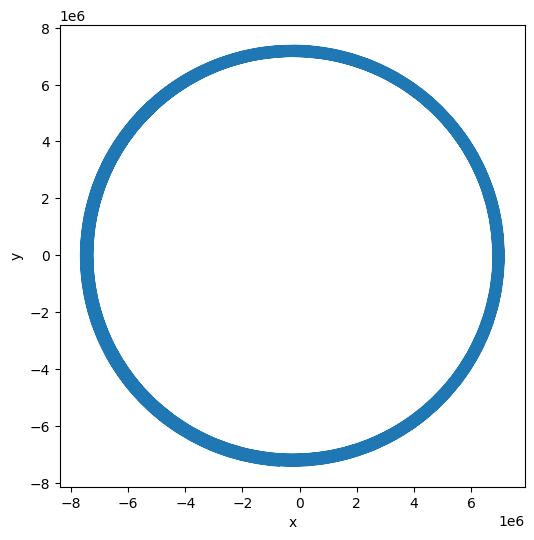

In [157]:
np.random.seed(0)
dt_sim_arr = np.random.randint(1., 80., 5000) ### randomely generate timesteps
state = [R_EARTH + 400e3, 0, 0, 
         0, 7800, 0]
xs=[state]
for dt in dt_sim_arr:
    state = f(state, dt = dt)
    xs.append(state)

xs = np.array(xs)
# print(xs[:, :3])

plt.figure(figsize = (6,6))
plt.plot( xs[:, 0],xs[:, 1] ,  label = '')
plt.xlabel('x')
plt.ylabel('y')
# plt.title('')
# plt.legend()
# plt.grid()
plt.show()

# Define measurement function h(x)

In [7]:
def h_radar(x):
    """x is the state vector,
    this H function assumes radar sends positions in global coordinate system"""
    # return [x[0], x[2], x[4]]   # return x,y,z position if state order is (x, vx, y, vy, z, vz)
    return x[:3] # return x,y,z position if state order is (x,y,z,vx,vy,vz)



# Unscented KF

In [250]:
Q_discrete_white_noise(dim=2, dt=1, var=1)

array([[0.25, 0.5 ],
       [0.5 , 1.  ]])

In [9]:
# """ =============== Generate sigma points ================="""
# ### initialise UKF
# sigmas_generator = MerweScaledSigmaPoints(n=6, alpha=0.1, beta = 2., kappa= -3.)  #kappa = -3.
# ukf = UKF(dim_x=6, dim_z=3, fx = f, hx = h_radar, dt = dt, points=sigmas_generator) # take f, h from Jai and Vijay
# # print(ukf.Q)


# ### Define items in UKF ============================
# ### initial state values of (x,y,z,vx,vy,vz)
# ukf.x = np.array([R_EARTH + 400e3, 1, -1,
#                   1, 7700, 1])  # initial state

# ukf.P = np.diag([50**2, 50**2, 50**2,
#                  5**2, 5**2, 5**2])    # experiment this

# ukf.Q = np.zeros((6,6))
# ukf.Q[np.ix_([0,3], [0,3])] = Q_discrete_white_noise(dim=2, dt=dt, var=1)  # Q matrix for x and vx
# ukf.Q[np.ix_([1,4], [1,4])] = Q_discrete_white_noise(dim=2, dt=dt, var=1)  # Q matrix for y and vy
# ukf.Q[np.ix_([2,5], [2,5])] = Q_discrete_white_noise(dim=2, dt=dt, var=1)  # Q matrix for z and vz



# # range_std = 10 # meters. change this!!!!!!!!!!!!!!!!!!!!!! (get from radar)
# # elev_std = math.radians(1)  # 1 degree in radians. change this!!!!!!!!!!!!!!!!!!!!!! (get from radar)
# # azim_std = math.radians(1)  # 1 degree in radians. change this!!!!!!!!!!!!!!!!!!!!!1 (get from radar)
# # ukf.R = np.diag([range_std**2, elev_std**2, azim_std**2])

# """### radar measurement noise (for the simple UKF only! change this!!!!!!!!!!!!!!!!!!!!!!)"""
# x_std = 50  # meters. 
# y_std = 50  # meters.
# z_std = 10  # meters. 
# ukf.R = np.diag([x_std**2, y_std**2, z_std**2])



In [158]:
def satellite_UKF(fx, hx, dt=1.0):
    """ =============== Generate sigma points ================="""
    ### initialise UKF
    sigmas_generator = MerweScaledSigmaPoints(n=6, alpha=0.1, beta = 2., kappa= -3.)  #kappa = -3.
    ukf = UKF(dim_x=6, dim_z=3, fx = fx, hx = hx, dt = dt, points=sigmas_generator) # take f, h from Jai and Vijay
    # print(ukf.Q)


    """ ============== Define items in UKF ============================"""
    ### initial state values of (x,y,z,vx,vy,vz)
    ukf.x = np.array([R_EARTH + 400e3, 1, -1,
                    1, 7700, 1])  # initial state
    ### initial uncertainty of the state
    ukf.P = np.diag([50**2, 50**2, 50**2,
                    5**2, 5**2, 5**2])    # experiment this
    ### uncertainty in the process model
    ukf.Q = np.zeros((6,6))
    ukf.Q[np.ix_([0,3], [0,3])] = Q_discrete_white_noise(dim=2, dt=dt, var=1)  # Q matrix for x and vx
    ukf.Q[np.ix_([1,4], [1,4])] = Q_discrete_white_noise(dim=2, dt=dt, var=1)  # Q matrix for y and vy
    ukf.Q[np.ix_([2,5], [2,5])] = Q_discrete_white_noise(dim=2, dt=dt, var=1)  # Q matrix for z and vz


    # range_std = 10 # meters. change this!!!!!!!!!!!!!!!!!!!!!! (get from radar)
    # elev_std = math.radians(1)  # 1 degree in radians. change this!!!!!!!!!!!!!!!!!!!!!! (get from radar)
    # azim_std = math.radians(1)  # 1 degree in radians. change this!!!!!!!!!!!!!!!!!!!!!1 (get from radar)
    # ukf.R = np.diag([range_std**2, elev_std**2, azim_std**2])

    """### radar measurement noise (for the simple UKF only! change this!!!!!!!!!!!!!!!!!!!!!!)"""
    x_std = 500  # meters. 
    y_std = 500  # meters.
    z_std = 10  # meters. 
    ukf.R = np.diag([x_std**2, y_std**2, z_std**2])

    ukf.save_x_prior = True
    return ukf

## Run UKF with varying time steps

In [159]:
"""Initialise satellite, radar and UKF========================"""
# np.random.seed(0)  # for reproducibility
satellite_pos_true = SatelliteTraj(pos=[R_EARTH + 1000e3, 0, 0], vel=[0, 7700, 0], vel_std=0.0001)  # true satellite position with noise
radar = RadarStation(radar_pos = (0,0,0), x_std=50000, y_std=50, z_std=10)
ukf = satellite_UKF(fx = f, hx = h_radar, dt=1)

"""### Run UKF with varying time steps ========================""" 
num_iterations = 15
# dt_sim = 60.
dt_sim_arr = np.random.randint(1., 80., num_iterations) ### randomely generate timesteps

xs_true = []
xs_prior = []
zs = []
xs = []

time_duration = 0.0 # initialise time duration
for iter, dt_sim in enumerate(dt_sim_arr):
    time_duration += dt_sim
    sate_pos = satellite_pos_true.update(dt = dt_sim)
    xs_true.append(sate_pos)

    ### Get radar measurement
    # sate_pos = radar.reading_of(satellite_pos=sate_pos)  # true satellite position
    z = radar.noisy_reading(satellite_pos= sate_pos, time = time_duration)
    zs.append(z)

    ### run UKF
    dt = zs[iter][-1] - zs[iter-1][-1] if iter > 0 else dt_sim
    print("iteration=", iter, "\ttimestep =", dt, "\t time duration = ", time_duration)
    ukf.predict(dt=dt)      # UKF can predict at varying timesteps
    xs_prior.append(ukf.x_prior)
    # ukf.update(z, R=ukf.R, hx=h_radar, args=None)
    ukf.update(z=z[:3], R=ukf.R, hx=h_radar)  # update with radar measurement
    x_new = ukf.x
    xs.append(ukf.x)  # store the estimated state
    # xs = np.append(xs, ukf.x)

xs_true = np.array(xs_true)
xs_prior = np.array(xs_prior)
zs = np.array(zs)
xs = np.array(xs)



iteration= 0 	timestep = 46 	 time duration =  46.0
iteration= 1 	timestep = 7.0 	 time duration =  53.0
iteration= 2 	timestep = 19.0 	 time duration =  72.0
iteration= 3 	timestep = 57.0 	 time duration =  129.0
iteration= 4 	timestep = 34.0 	 time duration =  163.0
iteration= 5 	timestep = 9.0 	 time duration =  172.0
iteration= 6 	timestep = 79.0 	 time duration =  251.0
iteration= 7 	timestep = 19.0 	 time duration =  270.0
iteration= 8 	timestep = 60.0 	 time duration =  330.0
iteration= 9 	timestep = 40.0 	 time duration =  370.0
iteration= 10 	timestep = 25.0 	 time duration =  395.0
iteration= 11 	timestep = 13.0 	 time duration =  408.0
iteration= 12 	timestep = 10.0 	 time duration =  418.0
iteration= 13 	timestep = 50.0 	 time duration =  468.0
iteration= 14 	timestep = 51.0 	 time duration =  519.0


# Plot

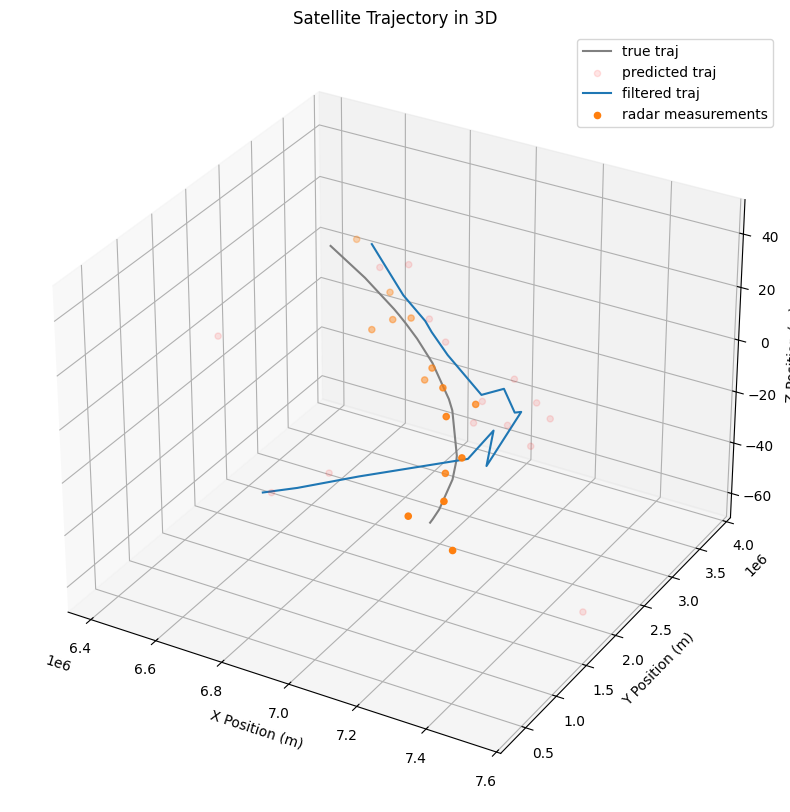

In [160]:
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d')
ax.plot(xs_true[:, 0] , xs_true[:, 1], xs_true[:, 2], color = 'grey', label = 'true traj')
ax.scatter(xs_prior[:, 0] , xs_prior[:, 1], xs_prior[:, 2], color = 'red', alpha = 0.1, label = 'predicted traj')

ax.plot(xs[:, 0] , xs[:, 1], xs[:, 2], label = 'filtered traj')
ax.scatter(zs[:, 0] , zs[:, 1], zs[:, 2], color = 'C1', label = 'radar measurements')
# ax.set_zlim(-10, 10)
ax.set_title('Satellite Trajectory in 3D')
ax.set_xlabel('X Position (m)')
ax.set_ylabel('Y Position (m)')
ax.set_zlabel('Z Position (m)')
plt.legend()
plt.show()

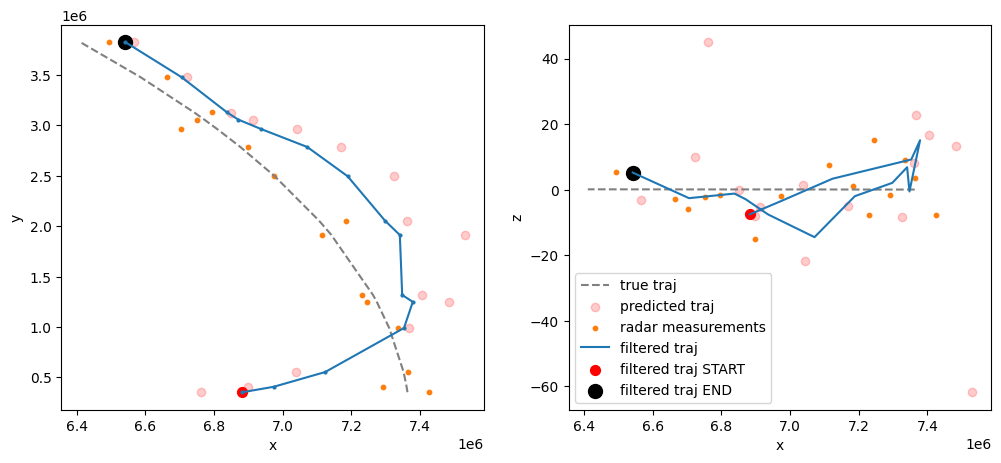

In [161]:
# plt.figure(figsize = (10,10))
fig, ax = plt.subplots(1,2, figsize = (12, 5), sharex = True)

# plt.plot(xs_true[:, 0] , xs_true[:, 1], label = '')
ax[0].plot(xs_true[:, 0] , xs_true[:, 1], '--', color = 'grey', label = 'true traj')
ax[0].scatter(xs_prior[:, 0] , xs_prior[:, 1], color = 'red', alpha = 0.2, label = 'predicted traj')
ax[0].scatter(zs[:, 0] , zs[:, 1], color = 'C1', s = 10, label = 'radar measurements')
ax[0].plot(xs[:, 0] , xs[:, 1], "-o", markersize=2, label = 'filtered traj')
ax[0].scatter(xs[0, 0] , xs[0, 1], color = 'red', s=50, label = 'filtered traj START')
ax[0].scatter(xs[-1, 0] , xs[-1, 1], color = 'black', s=100, label = 'filtered traj END')
ax[0].set_xlabel('x')
ax[0].set_ylabel('y')

ax[1].plot(xs_true[:, 0] , xs_true[:, 2], '--', color = 'grey', label = 'true traj')
ax[1].scatter(xs_prior[:, 0] , xs_prior[:, 2], color = 'red', alpha = 0.2, label = 'predicted traj')
ax[1].scatter(zs[:, 0] , zs[:, 2], color = 'C1', s = 10, label = 'radar measurements')
ax[1].plot(xs[:, 0] , xs[:, 2],label = 'filtered traj')
ax[1].scatter(xs[0, 0] , xs[0, 2], color = 'red', s=50, label = 'filtered traj START')
ax[1].scatter(xs[-1, 0] , xs[-1, 2], color = 'black', s=100, label = 'filtered traj END')
ax[1].set_xlabel('x')
ax[1].set_ylabel('z')

plt.title('')
plt.legend()
# plt.grid()
plt.show()

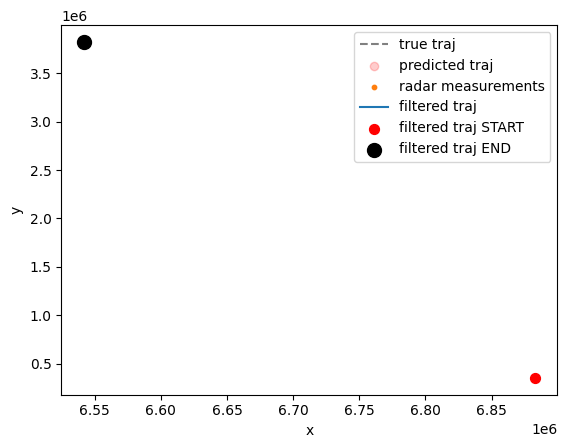

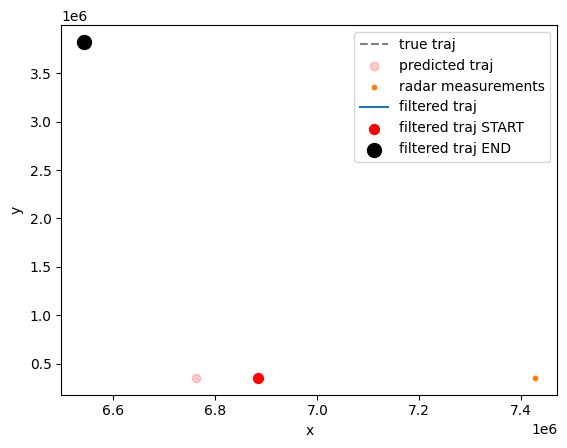

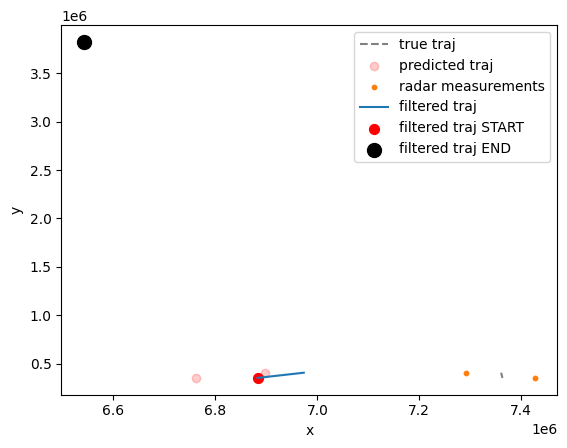

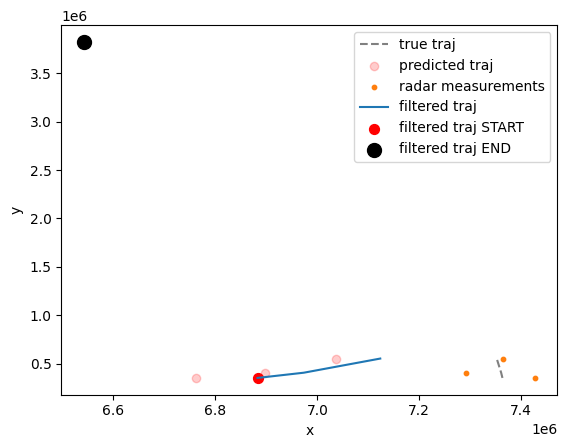

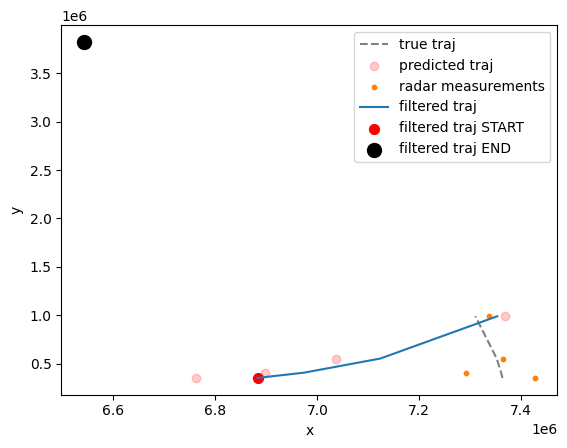

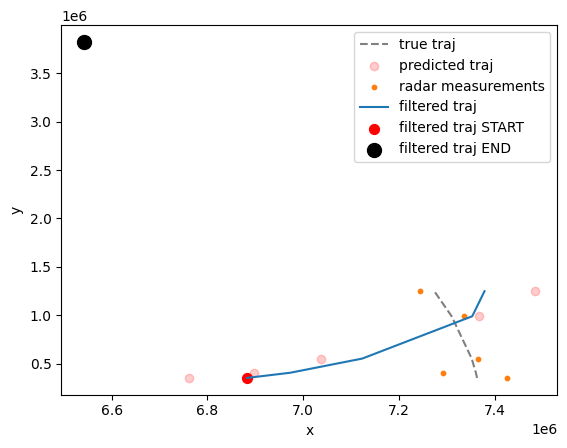

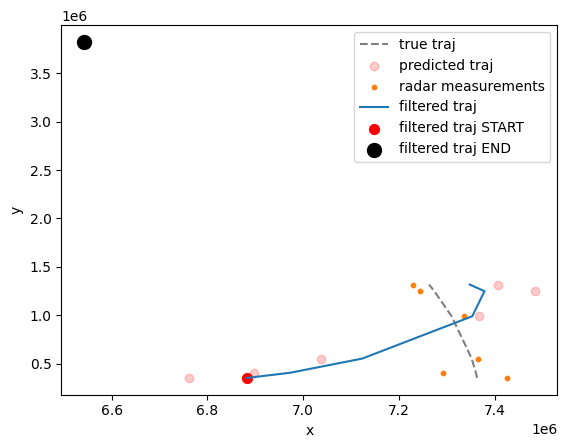

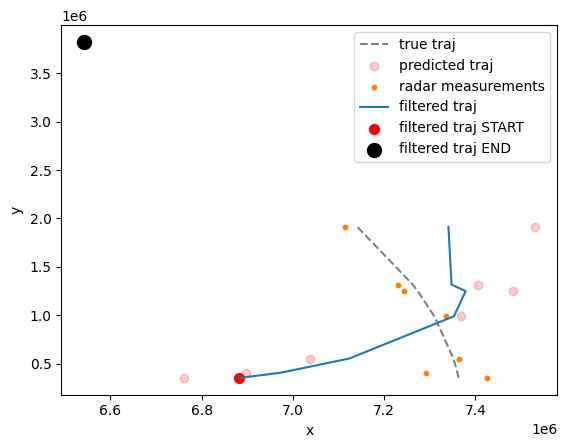

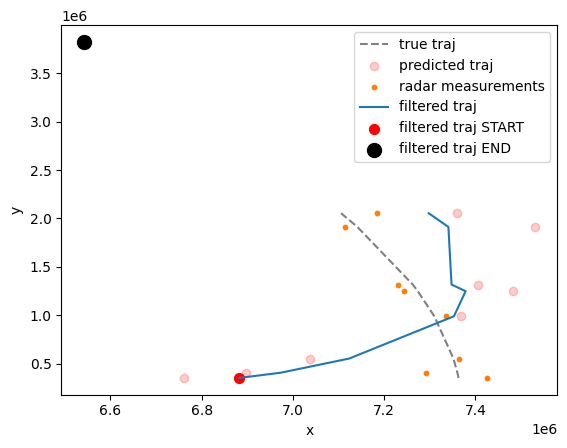

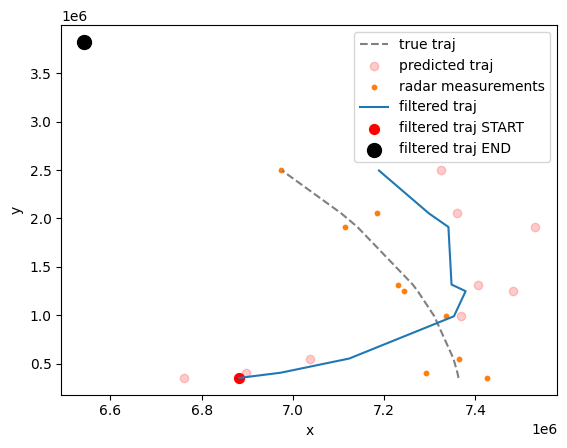

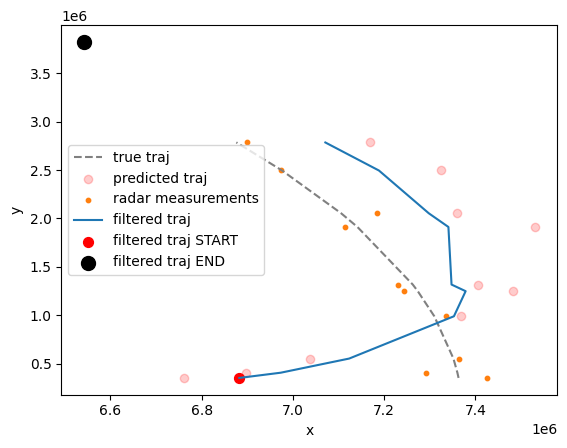

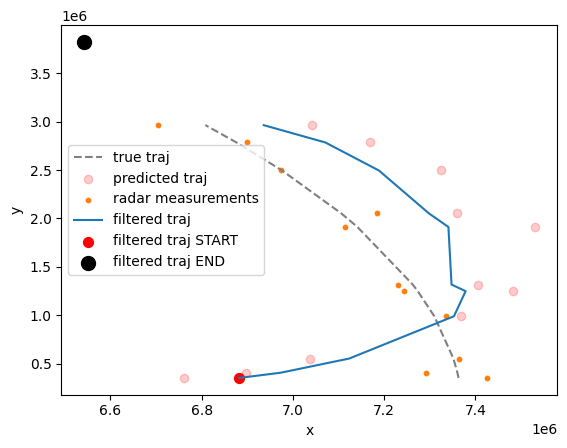

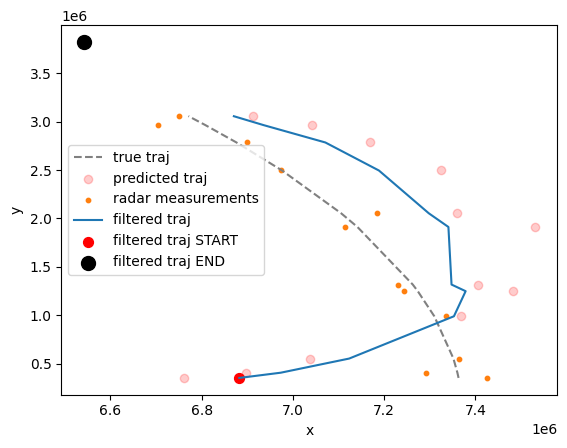

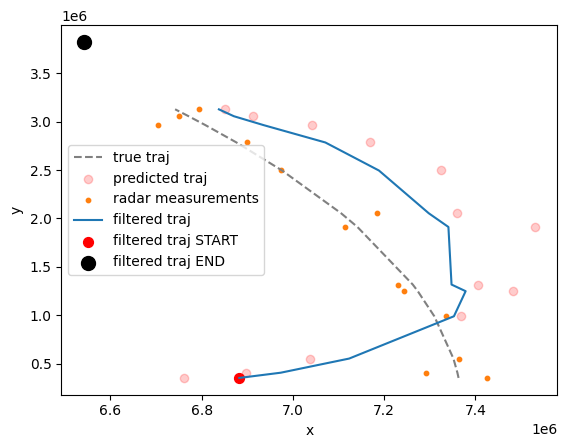

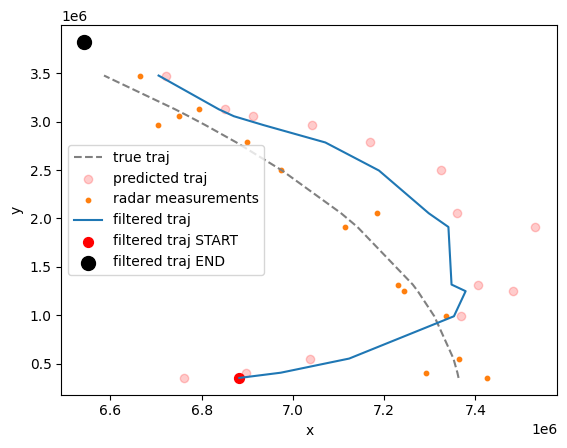

In [65]:
plt.figure()
for i in range(15):
    # plt.plot(xs_true[:, 0] , xs_true[:, 1], label = '')
    plt.plot(xs_true[:i, 0] , xs_true[:i, 1], '--', color = 'grey', label = 'true traj')
    plt.scatter(xs_prior[:i, 0] , xs_prior[:i, 1], color = 'red', alpha = 0.2, label = 'predicted traj')

    plt.scatter(zs[:i, 0] , zs[:i, 1], color = 'C1', s = 10, label = 'radar measurements')

    plt.plot(xs[:i, 0] , xs[:i, 1],label = 'filtered traj')
    plt.scatter(xs[0, 0] , xs[0, 1], color = 'red', s=50, label = 'filtered traj START')
    plt.scatter(xs[-1, 0] , xs[-1, 1], color = 'black', s=100, label = 'filtered traj END')

    plt.xlabel('x')
    plt.ylabel('y')
    plt.title('')
    plt.legend()
    # plt.grid()
    plt.show()

## Run UKF with varying time steps & batch processing

In [ ]:
test = [2,5,9,10]
np.array(test)[-3:] - np.array(test[-4:-1])
np.diff(test, )


array([3, 4, 1])

### Using batch_filter function

Caveat: doesn't return x_prior and P_prior.

In [153]:
"""Initialise satellite, radar and UKF========================"""
# np.random.seed(0)  # for reproducibility
satellite_pos_true = SatelliteTraj(pos=[R_EARTH + 1000e3, 0, 0], vel=[0, 7700, 0], vel_std=0.0001)  # true satellite position with noise
radar = RadarStation(radar_pos = (0,0,0), x_std=50000, y_std=50, z_std=10)
ukf = satellite_UKF(fx = f, hx = h_radar, dt=1)


"""Generate radar measurement batches and do batch processing in UKF"""
num_iterations = 500

xs_true = []
xs_prior = []
zs = []
xs = []
Ps = []
ts = [0.0]
### for every iteration, generate num_in_batch measurements, in each batch, the dt are varying according to dt_sim_arr.
### every time we receive a batch, perform batch process using that batch.

time_duration = 0.0 # initialise total time duration of the filtering process
for iter in range(num_iterations):
    num_in_batch = np.random.choice([5, 15, 25])  # random number of measurements in a batch
    dt_sim_arr = np.random.randint(1., 80., num_in_batch) ### randomely generate timesteps
    # zs_batch = []
    for dt_sim in dt_sim_arr:
        time_duration += dt_sim
        sate_pos = satellite_pos_true.update(dt_sim)
        xs_true.append(sate_pos)
        ### get radar measurement
        z = radar.noisy_reading(satellite_pos=sate_pos, time=time_duration)
        # zs_batch.append(z)
        zs.append(z)
        ts.append(z[:][3])
    print("iteration=", iter, "\tbatch length=", num_in_batch)
    # print("iteration=", iter, "\tbatch length=", num_in_batch, "time=", np.array(ts), 
    #       "\nvarying dt:", np.array(ts)[-num_in_batch:] - np.array(ts)[-num_in_batch-1:-1],
    #       "\nbatch:",  np.array(zs)[-num_in_batch:])

    ### UKF with batch processing (each batch has varying timesteps)
    (x, cov) = ukf.batch_filter(zs=np.array(zs)[-num_in_batch:, :3], 
                                    dts=np.array(ts)[-num_in_batch:] - np.array(ts)[-num_in_batch-1:-1])
    # print("predicted x:", ukf.x_prior)
    # print("updated x:", x)
    
#     xs_prior.append(ukf.x_prior)
    xs.append(x)
    Ps.append(cov)


xs_true = np.array(xs_true)
# xs_prior = np.array(xs_prior)
zs = np.array(zs)
ts = np.array(ts)
xs = np.concatenate(xs, axis=0)
Ps = np.concatenate(Ps, axis=0)
# xs = np.array(xs)
# Ps = np.array(Ps)


iteration= 0 	batch length= 15
iteration= 1 	batch length= 15
iteration= 2 	batch length= 25
iteration= 3 	batch length= 5
iteration= 4 	batch length= 5
iteration= 5 	batch length= 5
iteration= 6 	batch length= 15
iteration= 7 	batch length= 5
iteration= 8 	batch length= 15
iteration= 9 	batch length= 15
iteration= 10 	batch length= 15
iteration= 11 	batch length= 5
iteration= 12 	batch length= 5
iteration= 13 	batch length= 5
iteration= 14 	batch length= 5
iteration= 15 	batch length= 5
iteration= 16 	batch length= 25
iteration= 17 	batch length= 5
iteration= 18 	batch length= 25
iteration= 19 	batch length= 25
iteration= 20 	batch length= 25
iteration= 21 	batch length= 5
iteration= 22 	batch length= 25
iteration= 23 	batch length= 25
iteration= 24 	batch length= 5
iteration= 25 	batch length= 25
iteration= 26 	batch length= 5
iteration= 27 	batch length= 15
iteration= 28 	batch length= 15
iteration= 29 	batch length= 15
iteration= 30 	batch length= 25
iteration= 31 	batch length= 15

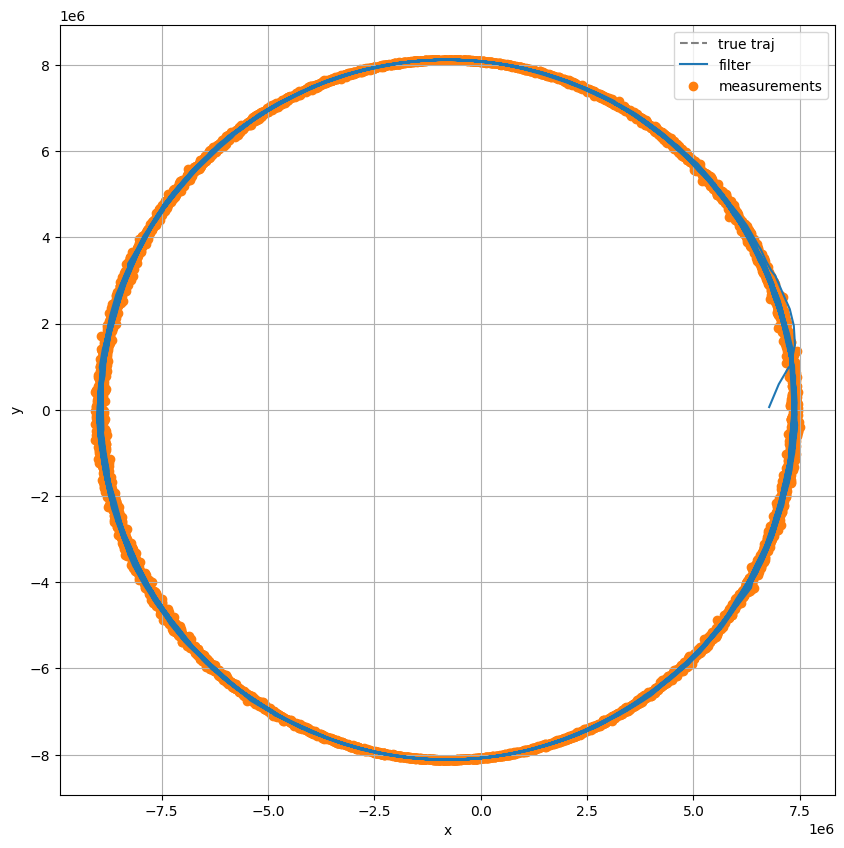

In [154]:
plt.figure(figsize = (10,10))
plt.plot(xs_true[:, 0] , xs_true[:, 1], '--', color='grey', label = 'true traj')
plt.plot(xs[:, 0] , xs[:, 1],  color='C0', label = 'filter')
plt.scatter(zs[:, 0], zs[:, 1], color = 'C1', label='measurements')
plt.xlabel('x')
plt.ylabel('y')
plt.title('')
plt.legend()
plt.grid()
plt.show()

### Using for loop

In [ ]:
"""Initialise satellite, radar and UKF========================"""
# np.random.seed(0)  # for reproducibility
satellite_pos_true = SatelliteTraj(pos=[R_EARTH + 1500e3, 0, 0], vel=[0, 7600, 0], vel_std=0.)  # true satellite position with noise
radar = RadarStation(radar_pos = (0,0,0), x_std=50000, y_std=50, z_std=10)
ukf = satellite_UKF(fx = f, hx = h_radar, dt=1)


"""Generate radar measurement batches and do batch processing in UKF"""
num_iterations = 10

xs_true = []
xs_prior = []
zs = []
xs = []
Ps = []
ts = [0.0]
### for every iteration, generate num_in_batch measurements, in each batch, the dt are varying according to dt_sim_arr.
### every time we receive a batch, perform batch process using that batch.

time_duration = 0.0 # initialise total time duration of the filtering process
for iter in tqdm(range(num_iterations)):
    num_in_batch = np.random.choice([5, 15, 25])  # random number of measurements in a batch
    dt_sim_arr = np.random.randint(10., 200., num_in_batch) ### randomely generate timesteps
    # zs_batch = []
    for dt_sim in dt_sim_arr:
        time_duration += dt_sim
        sate_pos = np.concatenate(satellite_pos_true.update(dt_sim)).reshape(1,-1).flatten()
        # print(sate_pos)
        xs_true.append(sate_pos)
        ### get radar measurement
        z = np.array(radar.noisy_reading(satellite_pos=sate_pos[:3], time=time_duration))
        # print(z)
        # zs_batch.append(z)
        zs.append(z)
        ts.append(z[3])
        # print(np.array(ts), np.array(ts).shape)
        if np.linalg.norm(sate_pos[:3]) - R_EARTH <=0: break

    # print("iteration=", iter, "\tbatch length=", num_in_batch, "\tts=", ts)
    # print("iteration=", iter, "\tbatch length=", num_in_batch, "\nvarying dt:", np.array(ts)[-num_in_batch:] - np.array(ts)[-num_in_batch-1:-1])
    # print("iteration=", iter, "\tbatch length=", num_in_batch, "time=", np.array(ts), 
    #       "\nvarying dt:", np.array(ts)[-num_in_batch:] - np.array(ts)[-num_in_batch-1:-1],
    #       "\nbatch:",  np.array(zs)[-num_in_batch:])

    ### UKF with batch processing (each batch has varying timesteps) =======================================
    # (x, cov) = ukf.batch_filter(zs=np.array(zs)[-num_in_batch:, :3], 
    #                                 dts=np.array(ts)[-num_in_batch:] - np.array(ts)[-num_in_batch-1:-1])
    # print(np.array(ts)[-num_in_batch:])
    # print(np.array(ts)[-num_in_batch-1:-1])
    for i, (z, dt) in enumerate(zip(np.array(zs)[-num_in_batch:, :],
                                    np.array(ts)[-num_in_batch:] - np.array(ts)[-num_in_batch-1:-1])):
        ukf.predict(dt=dt)
        xs_prior.append(ukf.x_prior)
        ukf.update(z[:3])
        x_post = ukf.x
        xs.append(x_post)
        x_cov = ukf.P
        Ps.append(x_cov)
        # print(np.random.multivariate_normal(mean=x_post, cov=x_cov, size=5))


xs_true = np.array(xs_true)
xs_prior = np.array(xs_prior)
zs = np.array(zs)
ts = np.array(ts)
# xs = np.concatenate(xs, axis=0)
# Ps = np.concatenate(Ps, axis=0)
xs = np.array(xs)
Ps = np.array(Ps)


  0%|          | 0/10 [00:00<?, ?it/s]

[[ 7.38605385e+06  9.67906097e+05  2.34911533e+01  4.33225425e+03
   7.58083927e+03  8.25895166e-01]
 [ 7.38614587e+06  9.67896385e+05 -1.35114100e+00  4.33404110e+03
   7.58147714e+03  8.65830365e-01]
 [ 7.38581478e+06  9.67179668e+05 -4.09885073e+00  4.33077187e+03
   7.57512077e+03 -4.25155881e-01]
 [ 7.38606924e+06  9.68193389e+05 -1.59943148e+00  4.33394839e+03
   7.58189570e+03  3.73602614e-01]
 [ 7.38614843e+06  9.67777986e+05  1.83399592e+01  4.33423375e+03
   7.58144333e+03 -8.44707991e-01]]
[[ 7.74483876e+06  1.55964803e+06 -3.15399407e+00  3.99366415e+03
   7.47308009e+03  4.03223985e-01]
 [ 7.74433561e+06  1.55952209e+06 -8.86419319e-01  3.99024180e+03
   7.47553525e+03  7.83420646e-01]
 [ 7.74535339e+06  1.56026702e+06 -1.87196604e+01  3.99744925e+03
   7.47741424e+03 -1.60101037e-01]
 [ 7.74469901e+06  1.55893538e+06 -1.92140354e+01  3.99498870e+03
   7.47109426e+03 -6.51057735e-01]
 [ 7.74477100e+06  1.55968844e+06  1.06883379e+01  3.99579532e+03
   7.47372527e+03  8.424

 20%|██        | 2/10 [00:00<00:01,  7.72it/s]

[[-4.48494472e+06  8.52298339e+06  1.02800134e+01 -6.06781283e+03
  -2.12576763e+03  1.70720855e-01]
 [-4.48521970e+06  8.52278173e+06 -1.05237510e+01 -6.06458907e+03
  -2.12454207e+03  3.24630249e-01]
 [-4.48485090e+06  8.52291859e+06 -1.53978305e+01 -6.06337232e+03
  -2.12328732e+03 -1.04640476e+00]
 [-4.48416532e+06  8.52283007e+06 -2.96747968e+00 -6.06236718e+03
  -2.12537333e+03  1.03441585e+00]
 [-4.48462839e+06  8.52316769e+06 -2.99095026e+01 -6.06304258e+03
  -2.12479646e+03 -1.82206383e+00]]
[[-4.51342925e+06  8.49722260e+06 -2.12968668e+00 -5.88356484e+03
  -2.17248024e+03 -6.69519240e-01]
 [-4.51330327e+06  8.49688561e+06  3.57152371e+00 -5.88031216e+03
  -2.17484312e+03 -8.45486851e-01]
 [-4.51346645e+06  8.49753841e+06 -1.69651754e+00 -5.88181157e+03
  -2.16809510e+03  1.31085295e+00]
 [-4.51309823e+06  8.49742179e+06 -1.47756549e+01 -5.88089943e+03
  -2.17255201e+03  1.79359152e+00]
 [-4.51302954e+06  8.49686709e+06 -1.39854969e+00 -5.88208911e+03
  -2.17299573e+03 -9.929

 40%|████      | 4/10 [00:00<00:00, 10.19it/s]

[[-9.62395746e+06 -3.65928934e+06  6.83299824e+00  2.44030681e+03
  -5.29203621e+03 -9.97181756e-01]
 [-9.62365102e+06 -3.65888396e+06  1.20686978e+01  2.44113516e+03
  -5.29268782e+03 -9.66511434e-01]
 [-9.62358774e+06 -3.65884221e+06  1.87137555e+01  2.44107029e+03
  -5.29058477e+03 -8.90637816e-02]
 [-9.62435420e+06 -3.65934936e+06  2.75502501e+00  2.43821511e+03
  -5.29269937e+03  1.16829106e+00]
 [-9.62366993e+06 -3.65832214e+06  1.27660505e+01  2.44243303e+03
  -5.28938628e+03 -9.18258454e-02]]
[[-9.45821332e+06 -4.02702246e+06  1.79097973e+01  2.64790997e+03
  -5.19809135e+03 -7.83203351e-01]
 [-9.45843404e+06 -4.02678679e+06  1.55101049e+01  2.64765957e+03
  -5.19804487e+03  9.25098627e-01]
 [-9.45821180e+06 -4.02580564e+06  2.38092046e+01  2.64801220e+03
  -5.19164919e+03 -1.45096563e+00]
 [-9.45793196e+06 -4.02649124e+06  1.90753197e+01  2.64913489e+03
  -5.19530769e+03  1.07563853e+00]
 [-9.45841700e+06 -4.02672423e+06  1.31789859e+01  2.64515944e+03
  -5.19618830e+03 -9.806

 60%|██████    | 6/10 [00:00<00:00,  8.13it/s]

[[ 6.62681324e+06 -4.60290184e+06  1.53093042e+01  3.85706743e+03
   6.39824684e+03  4.46687896e-01]
 [ 6.62646187e+06 -4.60296372e+06 -1.01346035e+01  3.85616226e+03
   6.39750737e+03 -5.12100355e-01]
 [ 6.62674938e+06 -4.60234420e+06 -5.04523761e+00  3.85874890e+03
   6.40355913e+03 -2.25697525e+00]
 [ 6.62712007e+06 -4.60273192e+06 -9.19496184e+00  3.86138991e+03
   6.39546971e+03 -1.41514976e+00]
 [ 6.62769939e+06 -4.60225133e+06  1.03526687e+01  3.85977970e+03
   6.39977635e+03 -1.39924534e+00]]
[[ 6.69349335e+06 -4.49968747e+06 -1.15820752e+01  3.78986811e+03
   6.45244981e+03 -2.72881880e-01]
 [ 6.69364995e+06 -4.49955814e+06 -6.39035459e+00  3.79488248e+03
   6.45256086e+03  8.58916960e-01]
 [ 6.69342533e+06 -4.50000753e+06 -1.23934456e+01  3.79356225e+03
   6.45122114e+03 -5.01907033e-01]
 [ 6.69326462e+06 -4.50058203e+06 -8.51429615e+00  3.79168329e+03
   6.45039296e+03 -9.90715921e-01]
 [ 6.69278863e+06 -4.49996554e+06 -1.96366305e+01  3.79155499e+03
   6.45511029e+03  6.525

100%|██████████| 10/10 [00:01<00:00, 10.62it/s]

[[-3.07901978e+06  8.89859406e+06 -1.16757416e+00 -6.38179069e+03
  -1.22278989e+03  2.82259134e-01]
 [-3.07947942e+06  8.89842023e+06 -1.96551025e+01 -6.38479766e+03
  -1.21951888e+03 -6.76749471e-01]
 [-3.07956094e+06  8.89867107e+06 -2.69142840e+01 -6.38391062e+03
  -1.22181671e+03  1.71673390e+00]
 [-3.07946389e+06  8.89808657e+06 -2.02387579e+01 -6.38160404e+03
  -1.22259218e+03 -1.22974421e+00]
 [-3.07913040e+06  8.89869314e+06  3.18990861e+00 -6.38331524e+03
  -1.22100255e+03 -5.24019346e-01]]
[[-3.87422497e+06  8.72189500e+06  7.45023913e+00 -6.31358219e+03
  -1.71606618e+03  1.00099768e+00]
 [-3.87430324e+06  8.72142317e+06 -6.76116170e+00 -6.30991489e+03
  -1.71712683e+03 -1.78619157e+00]
 [-3.87347663e+06  8.72198974e+06 -9.67634414e-01 -6.30928762e+03
  -1.71654663e+03  4.59872589e-01]
 [-3.87403930e+06  8.72202521e+06  1.05433281e+01 -6.31276972e+03
  -1.71518613e+03 -5.40732056e-01]
 [-3.87474342e+06  8.72174847e+06  3.60081672e+00 -6.31397896e+03
  -1.71701853e+03  7.721

100%|██████████| 10/10 [00:01<00:00,  9.78it/s]


In [434]:
ts[-1]

np.float64(15649.0)

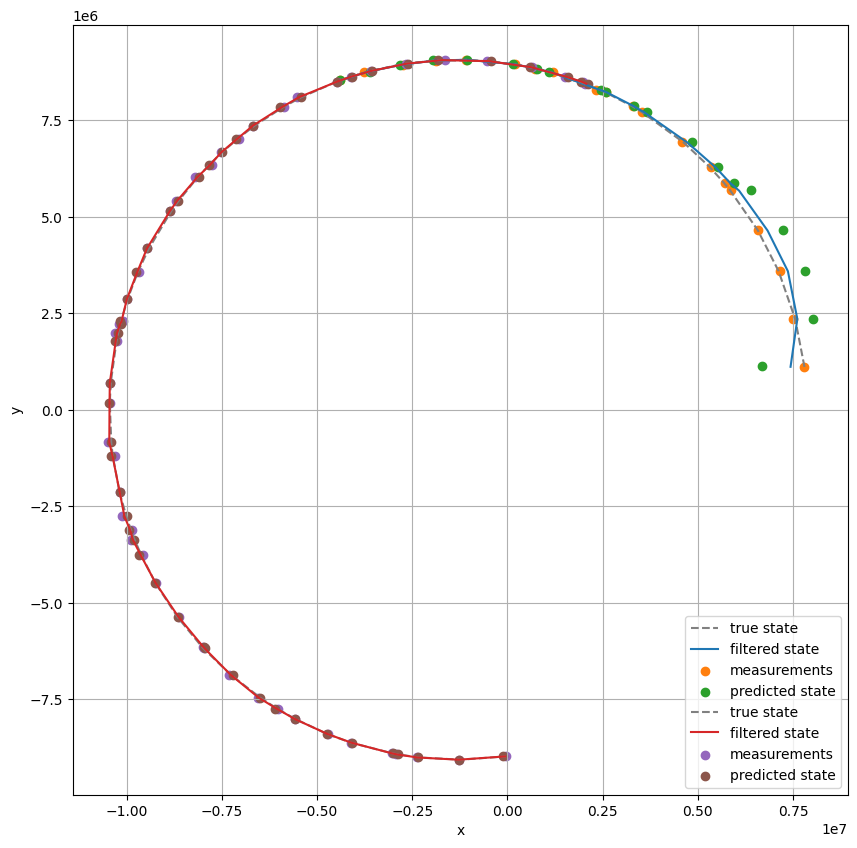

In [435]:
plt.figure(figsize = (10,10))
plt.plot(xs_true[:20, 0] , xs_true[:20, 1], '--', color='grey', label = 'true state')
plt.plot(xs[:20, 0] , xs[:20, 1],  color='C0', label = 'filtered state')
plt.scatter(zs[:20, 0], zs[:20, 1], color = 'C1', label='measurements')
plt.scatter(xs_prior[:20, 0], xs_prior[:20, 1], color = 'C2', label='predicted state')

plt.plot(xs_true[-50:, 0] , xs_true[-50:, 1], '--', color='grey', label = 'true state')
plt.plot(xs[-50:, 0] , xs[-50:, 1],  color='C3', label = 'filtered state')
plt.scatter(zs[-50:, 0], zs[-50:, 1], color = 'C4', label='measurements')
plt.scatter(xs_prior[-50:, 0], xs_prior[-50:, 1], color = 'C5', label='predicted state')

plt.xlabel('x')
plt.ylabel('y')
plt.title('')
plt.legend()
plt.grid()
plt.show()

# Predicting the landing position

In [171]:
ukf.x

array([-3.91373745e+06,  7.49511535e+06,  6.63671231e-01, -6.16608432e+03,
       -2.58065693e+03,  3.13419404e-02])

In [170]:
ukf.x_post

array([-3.91373745e+06,  7.49511535e+06,  6.63671231e-01, -6.16608432e+03,
       -2.58065693e+03,  3.13419404e-02])

In [167]:
ukf.P

array([[ 9.98864560e+04, -7.18171568e+02, -5.09045735e-06,
         4.13559355e+02, -8.23311332e+00,  3.93212195e-07],
       [-7.18171568e+02,  1.01366887e+05,  9.74623127e-06,
        -8.25532680e+00,  4.27439300e+02, -7.41279518e-07],
       [-5.09045735e-06,  9.74623127e-06,  9.76096204e+01,
        -2.27580036e-08,  3.93865110e-08,  2.11132402e+00],
       [ 4.13559355e+02, -8.25532680e+00, -2.27580036e-08,
         4.20457735e+00, -3.85941694e-02,  6.01484737e-09],
       [-8.23311332e+00,  4.27439300e+02,  3.93865110e-08,
        -3.85941694e-02,  4.25810966e+00, -7.97454898e-09],
       [ 3.93212195e-07, -7.41279518e-07,  2.11132402e+00,
         6.01484737e-09, -7.97454898e-09,  1.05340374e+00]])

In [ ]:
x_post_sample = np.random.multivariate_normal(mean=ukf.x, cov=ukf.P, size=2)

array([[-3.91333877e+06,  7.49534065e+06, -2.02757314e+01,
        -6.16328865e+03, -2.57816956e+03, -1.14994100e+00],
       [-3.91385673e+06,  7.49500188e+06, -2.89661707e+00,
        -6.16631513e+03, -2.58048220e+03,  1.58482575e-01]])

In [ ]:
t_span_from_until = (z[3], z[3]+16000000)   # integrate from the time at measurement to 6 months later.
solve_ivp(fun=ode,
          t_span=t_span_from_until,
          y0= ukf.x[:3],    # use [x,y,z] of the updated state
          method='RK45',    
          t_eval=t_span_from_until[1],
          events=)

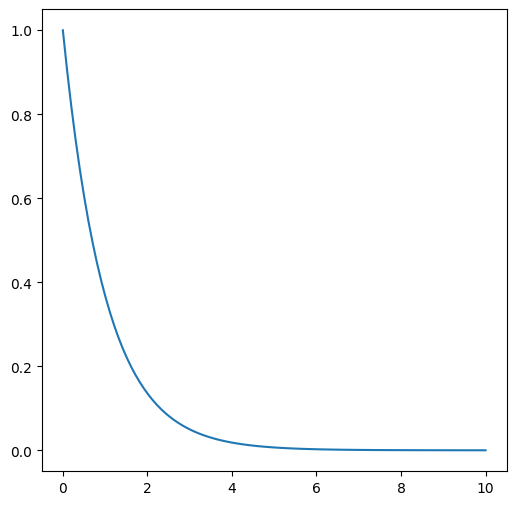

[array([[0.1]])]


In [243]:
def test_ode(t, y):
    return -y

y0 = [1.0]
t_span_interval=[0., 10.]
t_evals=np.linspace(0, 10, 100)


sol = solve_ivp(fun=test_ode, t_span=t_span_interval, y0=y0, method='RK45',t_eval=t_evals)
solution=sol.y.flatten()
# print(solution)
plt.figure(figsize = (6,6))
plt.plot(t_evals, solution)
# plt.xscale('log', base = 10)
# plt.yscale('log', base = 10)
plt.show()

sol2 = solve_ivp(fun=test_ode, t_span=t_span_interval, y0=y0, method='RK45',t_eval=[t_span_interval[1]])
# print(sol2.y)

def event_test(t,y):
    return np.linalg.norm(y)-0.1

event_test.terminal=True
event_test.direction = -1
sol3 = solve_ivp(fun=test_ode, t_span=t_span_interval, y0=y0, method='RK45',t_eval=[t_span_interval[1]], events=event_test)
# print(sol3.y)
# print(len(sol3.y))
# print(sol3.t_events, sol3.y_events)
if sol3.success and len(sol3.y) > 0:
    print(sol3.y)
elif sol3.success and len(sol3.y) ==0:
    print(sol3.y_events)

In [238]:
sol3.success

True

project landing positions

In [441]:
def stop_condition(t, y):
        # Stop when altitude <= 0
        if t == 0:
            return 1.0  # Don't trigger at initial step
        # x,y,z = y[:3]
        r = np.linalg.norm(y[:3])
        altitude = r - R_EARTH
        return altitude

In [ ]:
"""Initialise satellite, radar and UKF========================"""
# np.random.seed(0)  # for reproducibility
satellite_pos_true = SatelliteTraj(pos=[R_EARTH + 800e3, 0, 0], vel=[0, 7200, 0], vel_std=0.)  # true satellite position with noise
radar = RadarStation(radar_pos = (0,0,0), x_std=50000, y_std=50, z_std=10)
ukf = satellite_UKF(fx = f, hx = h_radar, dt=1)


"""Generate radar measurement batches and do batch processing in UKF"""
num_iterations = 20

xs_true = []
xs_prior = []
zs = []
xs = []
Ps = []
ts = [0.0]
### for every iteration, generate num_in_batch measurements, in each batch, the dt are varying according to dt_sim_arr.
### every time we receive a batch, perform batch process using that batch.

time_duration = 0.0 # initialise total time duration of the filtering process
for iter in tqdm(range(num_iterations)):
    num_in_batch = np.random.choice([5, 15, 25])  # random number of measurements in a batch
    dt_sim_arr = np.random.randint(10., 50., num_in_batch) ### randomely generate timesteps
    # zs_batch = []
    for dt_sim in dt_sim_arr:
        time_duration += dt_sim
        sate_pos = np.concatenate(satellite_pos_true.update(dt_sim)).reshape(1,-1).flatten()
        if np.linalg.norm(sate_pos[:3]) - R_EARTH <=0: break 
        # print(sate_pos)
        xs_true.append(sate_pos)
        ### get radar measurement
        z = np.array(radar.noisy_reading(satellite_pos=sate_pos[:3], time=time_duration))
        # print(z)
        # zs_batch.append(z)
        zs.append(z)
        ts.append(z[3])
        # print(np.array(ts), np.array(ts).shape)
    if np.linalg.norm(sate_pos[:3]) - R_EARTH <=0: break

    # print("iteration=", iter, "\tbatch length=", num_in_batch, "\tts=", ts)
    # print("iteration=", iter, "\tbatch length=", num_in_batch, "\nvarying dt:", np.array(ts)[-num_in_batch:] - np.array(ts)[-num_in_batch-1:-1])
    # print("iteration=", iter, "\tbatch length=", num_in_batch, "time=", np.array(ts), 
    #       "\nvarying dt:", np.array(ts)[-num_in_batch:] - np.array(ts)[-num_in_batch-1:-1],
    #       "\nbatch:",  np.array(zs)[-num_in_batch:])

    ### UKF with batch processing (each batch has varying timesteps) =======================================
    for i, (z, dt, t) in enumerate(zip(np.array(zs)[-num_in_batch:, :],
                                    np.array(ts)[-num_in_batch:] - np.array(ts)[-num_in_batch-1:-1],
                                    np.array(ts))):
        ukf.predict(dt=dt)
        xs_prior.append(ukf.x_prior)
        ukf.update(z[:3])
        x_post = ukf.x
        xs.append(x_post)
        x_cov = ukf.P
        Ps.append(x_cov)
        
        """Predict landing ====================================================================="""
        altitude_val = np.linalg.norm(x_post[:3])- R_EARTH
        print("altitude=", altitude_val)
        if altitude_val <= 0:   # if state position is less than ? meters away from the earth
            break
        elif altitude_val <= 200e3: 
            print("============== predict landing ================")
            ### sample from the updated state distribution and predict landing position
            state_samples = np.random.multivariate_normal(mean=x_post, cov=x_cov, size=5)

            ### record the landing position (inertia coord), and landing time
            predicted_landing = []
            predicted_landing_time = []

            for state0 in state_samples:
                # t_eval_arr = np.linspace(ts[-1], ts[-1]+100000, 1000)
                stop_condition.terminal = True
                stop_condition.direction = -1
                start = ts[-1]
                end = start + 1000000
                landing = solve_ivp(fun=ode, t_span=[start, end], y0=state0, method='RK45', t_eval=[end], events= stop_condition)
                while (landing.success and len(landing.y)> 0):
                    end += 1000000
                    landing = solve_ivp(fun=ode, t_span=[start, end], y0=state0, method='RK45', t_eval=[end], events= stop_condition)
                if landing.success and len(landing.y)==0:
                    # print(landing.y_events, np.linalg.norm(landing.y_events[0][0][:3])-R_EARTH)
                    # print(landing.y_events[0][0][:3])
                    predicted_landing.append(landing.y_events[0][0][:3])
                    
                    # print(landing.t_events[0][0])
                    predicted_landing_time.append(landing.t_events[0][0])
            print(np.array(predicted_landing))
            print(np.array(predicted_landing_time))




xs_true = np.array(xs_true)
xs_prior = np.array(xs_prior)
zs = np.array(zs)
ts = np.array(ts)
# xs = np.concatenate(xs, axis=0)
# Ps = np.concatenate(Ps, axis=0)
xs = np.array(xs)
Ps = np.array(Ps)


  5%|▌         | 1/20 [00:00<00:01,  9.99it/s]

altitude= 409979.7037999667
altitude= 434416.17344733886
altitude= 508061.17799250316
altitude= 689568.0002977196
altitude= 764966.6103998972
altitude= 819246.8903445909
altitude= 855107.3321356401
altitude= 881862.5690054875
altitude= 883920.7044898048
altitude= 881661.775344925
altitude= 857187.6289141057
altitude= 882263.3704474131
altitude= 845440.2553028371
altitude= 846286.453142385
altitude= 839263.7441739533
altitude= 804493.2017791709
altitude= 807393.871935619
altitude= 786039.8074809322
altitude= 772483.493954612
altitude= 775332.0498487251
altitude= 734480.2102664486
altitude= 708087.879698135
altitude= 695978.0033212174
altitude= 660301.0905051082
altitude= 651068.6004828131
altitude= 632887.4653910212
altitude= 624948.6048633382
altitude= 630154.6687325649
altitude= 626742.6644366803


 10%|█         | 2/20 [00:00<00:02,  7.14it/s]

altitude= 630916.5319515644
altitude= 608695.3057152582
altitude= 598355.7689579288
altitude= 566381.3898611609
altitude= 553703.5414702483
altitude= 543836.8822635179
altitude= 531199.4956660969
altitude= 500036.7671608031
altitude= 500772.54730740655
altitude= 492728.95351640787
altitude= 463469.4178155698
altitude= 465169.72835682984
altitude= 448515.2573891161
altitude= 427386.80272848904
altitude= 410802.35220416076
altitude= 400722.2069124188
altitude= 385370.590233271
altitude= 365536.40076290164
altitude= 338963.8624320831
altitude= 324768.8273168709
altitude= 310822.33419298846
altitude= 293689.6161485743
altitude= 270870.41722471453
altitude= 249895.71711314935
altitude= 222122.39901209436
altitude= 207609.57721863594
altitude= 188500.41244627722
============== predict landing ================
[[-2.48924219e+06  5.86458134e+06 -9.08188021e+00]
 [-1.54401274e+06  6.18107318e+06 -1.81849082e+01]
 [-1.48503327e+06  6.19550782e+06 -3.09907906e+01]
 [-1.30282017e+06  6.23636918e+0

 15%|█▌        | 3/20 [00:00<00:02,  5.82it/s]

[[-5.49437844e+06  3.22512737e+06 -1.91925543e+02]
 [-1.24795698e+06  6.24757908e+06  6.01578229e+01]
 [-2.15522776e+06  5.99538442e+06  1.70466057e+01]
 [-2.06990340e+06  6.02537475e+06  1.44499637e+01]
 [-1.26477278e+06  6.24419657e+06  2.09983847e+01]]
[2544.75449064 7328.36882152 7467.56877698 7453.65185636 7333.39394992]
altitude= 147953.8665842684
============== predict landing ================
[[-5.02503113e+06  3.91646565e+06  5.94235012e+01]
 [-4.99941288e+06  3.94911514e+06 -1.22461211e+03]
 [-5.02087482e+06  3.92179257e+06 -2.88145694e+02]
 [-5.04199257e+06  3.89460548e+06 -3.78625587e+02]
 [-5.01624980e+06  3.92770653e+06 -6.37776701e+02]]
[2410.49350966 2405.3549271  2409.71380649 2413.89949846 2408.75585521]
altitude= 122864.20500739478
============== predict landing ================
[[-4.73335276e+06  4.26438888e+06 -2.78281802e+02]
 [-4.75666956e+06  4.23836474e+06  2.23696720e+02]
 [-4.71137093e+06  4.28866236e+06 -2.38831841e+02]
 [-4.75744039e+06  4.23749947e+06  4.4

In [ ]:
"""True landing position"""
xs_true[-1]

array([-3.92568786e+06,  5.01875126e+06,  0.00000000e+00,  3.92920327e+01,
       -5.02324558e+01,  0.00000000e+00])

### Verify landing time. Seems correct!!!

In [475]:
sat = SatelliteTraj(pos=[R_EARTH + 800e3, 0., 0.], vel=[0., 7200., 0.], vel_std=0.0)
num_iterations = 50000
xs = []
for _ in tqdm(range(num_iterations)):
    # print(sat.update(10))  # simulate 10-second intervals
    update_state = sat.update(dt = 10.)
    # print(update_state)
    xs.append(update_state)
    if np.linalg.norm(update_state[0]) - R_EARTH <=0: break

xs = np.array(xs)
xs = xs.reshape(xs.shape[0], -1)

  0%|          | 233/50000 [00:00<00:33, 1493.53it/s]


In [476]:
ts

array([   0.,   10.,   21.,   41.,   83.,  100.,  139.,  171.,  215.,
        248.,  280.,  313.,  359.,  370.,  391.,  414.,  458.,  486.,
        506.,  536.,  561.,  599.,  621.,  669.,  716.,  730.,  755.,
        774.,  815.,  864.,  883.,  912.,  953.,  991., 1009., 1043.,
       1068., 1117., 1130., 1144., 1182., 1195., 1236., 1284., 1320.,
       1335., 1363., 1402., 1448., 1474., 1499., 1531., 1574., 1616.,
       1665., 1696., 1744., 1790., 1823., 1872., 1892., 1915., 1936.,
       1966., 1981., 2003., 2026., 2072., 2092., 2127., 2170., 2195.,
       2206., 2243., 2284., 2323.])

In [472]:
np.linalg.norm([-4.74060695e+06,  4.25632315e+06,  2.10187615e+02]) - R_EARTH

np.float64(0.004378674551844597)

# Improve f(x)

In [483]:
G = 6.67430e-11                             # Gravitational constant (m^3 kg^-1 s^-2)
M_EARTH = 5.972e24                          # Mass of Earth (kg)
EARTH_SEMIMAJOR = 6378137.0                 # Radius of Earth (m)
EARTH_SEMIMINOR = 6356752.314245            # Semi-minor axis of Earth (m)
FLATTENING = 1/298.257223563                # Flattening of Earth (dimensionless)
E_SQUARED = FLATTENING * (2 - FLATTENING)   # Eccentricity squared (dimensionless)
ATMOSPHERE_HEIGHT = 120e3                   # Approximate height of the atmosphere (m)
CD = 2.2                                    # Drag coefficient (dimensionless)
A = 1.0                                     # Cross-sectional area of the satellite (m^2)
M_SAT = 500                                 # Mass of the satellite (kg)
RHO_0 = 1.225                               # Air density at sea level (kg/m^3)
H_SCALE = 8500                              # Scale height of the atmosphere (m)

In [484]:
class SatelliteTraj: 
    def __init__(self, pos, vel, vel_std):
        self.pos = np.asarray(pos, dtype=float)
        self.vel = np.asarray(vel, dtype=float)
        self.vel_std = vel_std 
        
    def update(self, dt):
        def atmospheric_density(altitude):
            # White noise as random perturbations of magnitude 0.1*RHO_0
            density = RHO_0 * np.exp(-altitude / H_SCALE)
            white_noise = np.random.normal(0, 0.05* density)
            if altitude > 0:
                return density + white_noise
            else:
                return 0
        def curvature_in_prime_vertical(phi):
            return EARTH_SEMIMAJOR / np.sqrt(1 - E_SQUARED * np.sin(phi)**2)

        # Returns latitude and height above ellipsoid
        # Calculates latitude for the WGS-84 model using Bowring's method
        # RESEARCH INTO FERRARI'S METHOD FOR BETTER ACCURACY
        # import numpy as np

        def latitude_iterator_and_height_plot(x, y, z):
            x = np.asarray(x)
            y = np.asarray(y)
            z = np.asarray(z)

            r = np.sqrt(x**2 + y**2)
            phi = np.arctan(z / (r * (1 - E_SQUARED)))
            phi_new = phi + 100  # ensures entry into the loop

            converged = np.zeros_like(phi, dtype=bool)
            max_iter = 100
            iter_count = 0

            while not np.all(converged) and iter_count < max_iter:
                phi[~converged] = phi_new[~converged]
                N = curvature_in_prime_vertical(phi)
                phi_new[~converged] = np.arctan2(z[~converged] + (N[~converged] * E_SQUARED) * np.sin(phi[~converged]),
                                                r[~converged] - (N[~converged] * E_SQUARED) * np.cos(phi[~converged]))
                converged[~converged] = np.abs(phi_new[~converged] - phi[~converged]) <= 1e-9
                iter_count += 1

            phi_final = phi_new
            N_final = curvature_in_prime_vertical(phi_final)
            height = (r / np.cos(phi_final)) - N_final
            height = np.maximum(height, 0)  # ensure non-negative height

            return phi_final, height


        def latitude_iterator_and_height(x, y, z):
            r = np.sqrt(x**2 + y**2)
            phi = np.arctan(z / (r * (1 - E_SQUARED)))
            phi_new = phi + 100
            
            while np.abs(phi_new - phi) > 1e-9:
                phi = phi_new
                N = curvature_in_prime_vertical(phi)
                phi_new = np.arctan2(z + (N * E_SQUARED) * np.sin(phi), r - (N * E_SQUARED) * np.cos(phi))
            
            height = (r / np.cos(phi)) - N
            if height < 0:
                height = 0
            
            return phi_new, height

        # Calculates the latitude, longitude and altitude of the satellite

        # Calculates the Earth's "radius" at the satellite's position
        # (Uses the WGS-84 ellipsoid model)
        # https://en.wikipedia.org/wiki/World_Geodetic_System#WGS84
        def earth_radius_WGS84(latitude):
            numerator = (EARTH_SEMIMAJOR**2 * np.cos(latitude))**2 + (EARTH_SEMIMINOR**2 * np.sin(latitude))**2
            denominator = (EARTH_SEMIMAJOR * np.cos(latitude))**2 + (EARTH_SEMIMINOR * np.sin(latitude))**2
            return np.sqrt(numerator / denominator)

        # Calculates the height of the satellite above an elliptical Earth
        # Latitude is calculated as an approximation for a non-spherical Earth
        def lat_long_height(x, y, z):
            r = np.sqrt(x**2 + y**2 + z**2)
            longitude = np.arctan2(z, np.sqrt(x**2 + y**2))
            latitude, height = latitude_iterator_and_height(x, y, z)
            R_earth = earth_radius_WGS84(latitude)
            height = r - R_earth
            return latitude, longitude, height

        def lat_long_height_plot(x, y, z):
            r = np.sqrt(x**2 + y**2 + z**2)
            longitude = np.arctan2(z, np.sqrt(x**2 + y**2))
            latitude, height = latitude_iterator_and_height_plot(x, y, z)
            R_earth = earth_radius_WGS84(latitude)
            height = r - R_earth
            return latitude, longitude, height
        
        def dynamics(t, state):
            x, y, z, vx, vy, vz = state
            r = np.sqrt(x**2 + y**2 + z**2)
            altitude = lat_long_height(x, y, z)[2]

            # Gravity
            F_gravity = -G * M_EARTH / r**2

            # Drag
            rho = atmospheric_density(altitude)
            v = np.sqrt(vx**2 + vy**2 + vz**2)
            F_drag_x = -0.5 * rho * CD * A * v * vx / M_SAT
            F_drag_y = -0.5 * rho * CD * A * v * vy / M_SAT
            F_drag_z = -0.5 * rho * CD * A * v * vz / M_SAT

            # Acceleration
            ax = F_gravity * (x / r) + F_drag_x
            ay = F_gravity * (y / r) + F_drag_y
            az = F_gravity * (z / r) + F_drag_z

            return [vx, vy, vz, ax, ay, az]
        
        def stop_condition(t, y):
            r = np.sqrt(y[0]**2 + y[1]**2 + y[2]**2)
            altitude = lat_long_height(y[0], y[1], y[2])[2]
            return altitude
        
        stop_condition.terminal = True
        stop_condition.direction = -1
        state0 = np.hstack((self.pos, self.vel)).flatten()

        sol = solve_ivp(dynamics, [0, dt], y0=state0, method='RK45', t_eval=[dt], events=stop_condition, rtol=1e-5, atol=1e-2)
        
        if sol.success and len(sol.y) > 0:
            # print(sol.y, type(sol.y))
            new_state = sol.y.flatten()
            self.pos = new_state[:3]
            self.vel = new_state[3:]

            # # Optionally apply Gaussian noise to velocity
            # if self.vel_std:
            #     self.vel += np.random.normal(0, self.vel_std, size=3)
            return self.pos, self.vel
        
        elif sol.success and len(sol.y)==0:
            # print(sol.y_events, type(sol.y_events))
            new_state = np.array(sol.y_events).flatten()
            self.pos = new_state[:3]
            self.vel = new_state[3:]
            return self.pos, self.vel
        else:
            print("Integration failed!")


In [521]:
### simulation
sat = SatelliteTraj(pos=[R_EARTH + 400e3, 0., 0.], vel=[-10., 7600., 1000.], vel_std=0.0)
num_iterations = 1000
xs = []
for _ in tqdm(range(num_iterations)):
    # print(sat.update(10))  # simulate 10-second intervals
    update_state = sat.update(dt = 10.)
    # print(update_state)
    xs.append(update_state)
    if np.linalg.norm(update_state[0]) - R_EARTH <=0: break

xs = np.array(xs)
xs = xs.reshape(xs.shape[0], -1)

100%|██████████| 1000/1000 [00:05<00:00, 198.45it/s]


In [516]:
xs

array([[ 6.77046530e+06,  7.59983736e+04,  9.99978600e+01,
        -9.69395803e+01,  7.59951207e+03,  9.99935798e+00],
       [ 6.76906123e+06,  1.51986988e+05,  1.99982880e+02,
        -1.83871194e+02,  7.59804826e+03,  9.99743193e+00],
       [ 6.76678794e+06,  2.27956086e+05,  2.99942219e+02,
        -2.70784306e+02,  7.59560866e+03,  9.99422192e+00],
       ...,
       [-6.47375292e+06,  7.27223486e+05,  9.56873008e+02,
        -8.70354343e+02, -7.79234080e+03, -1.02530800e+01],
       [-6.48198948e+06,  6.49250445e+05,  8.54276901e+02,
        -7.76938400e+02, -7.80207913e+03, -1.02658936e+01],
       [-6.48929132e+06,  5.71185628e+05,  7.51560037e+02,
        -6.83410977e+02, -7.81069540e+03, -1.02772308e+01]])

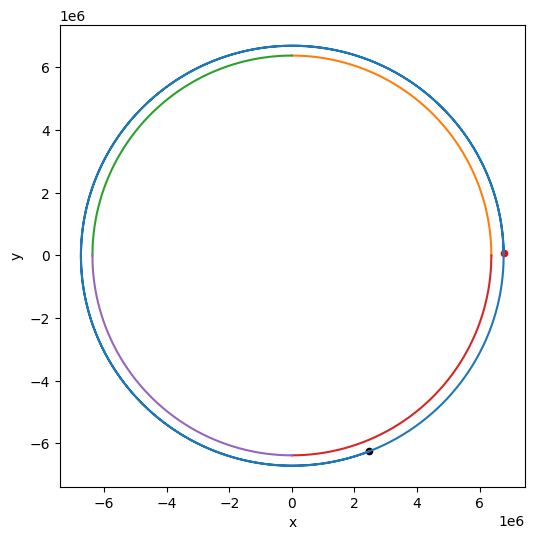

In [522]:
### plot (x,y)
x_axis = np.linspace(0, EARTH_SEMIMAJOR, 1000)
y_axis = np.sqrt(EARTH_SEMIMAJOR**2-x_axis**2)
plt.figure(figsize = (6,6))
plt.plot(xs[:, 0] , xs[:, 1], label = '')
plt.plot(x_axis, y_axis)
plt.plot(-x_axis, y_axis)
plt.plot(x_axis, -y_axis)
plt.plot(-x_axis, -y_axis)
plt.scatter(xs[0, 0] , xs[0, 1], label = 'start', color = 'red', s = 20)
plt.scatter(xs[-1, 0] , xs[-1, 1], label = 'end', color = 'black', s = 20)
# plt.xscale('log', base = 10)
# plt.yscale('log', base = 10)
plt.xlabel('x')
plt.ylabel('y')
plt.title('')
# plt.legend()
# plt.grid()
plt.show()

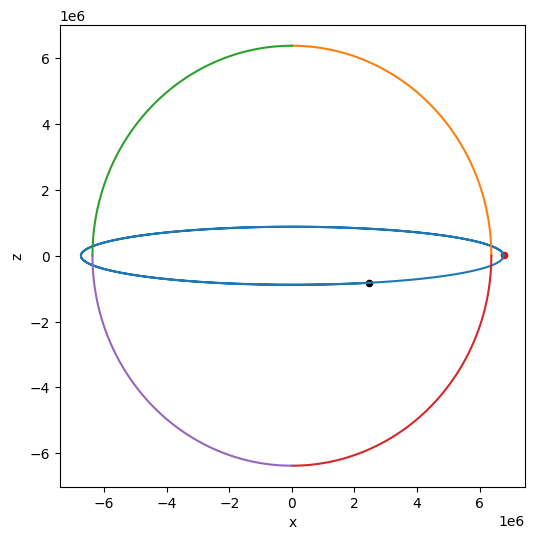

In [523]:
x_axis = np.linspace(0, EARTH_SEMIMAJOR, 1000)
y_axis = np.sqrt(EARTH_SEMIMAJOR**2-x_axis**2)
plt.figure(figsize = (6,6))
plt.plot(xs[:, 0] , xs[:, 2], label = '')
plt.plot(x_axis, y_axis)
plt.plot(-x_axis, y_axis)
plt.plot(x_axis, -y_axis)
plt.plot(-x_axis, -y_axis)
plt.scatter(xs[0, 0] , xs[0, 2], label = 'start', color = 'red', s = 20)
plt.scatter(xs[-1, 0] , xs[-1, 2], label = 'end', color = 'black', s = 20)
# plt.xscale('log', base = 10)
# plt.yscale('log', base = 10)
plt.xlabel('x')
plt.ylabel('z')
plt.title('')
# plt.legend()
# plt.grid()
plt.show()

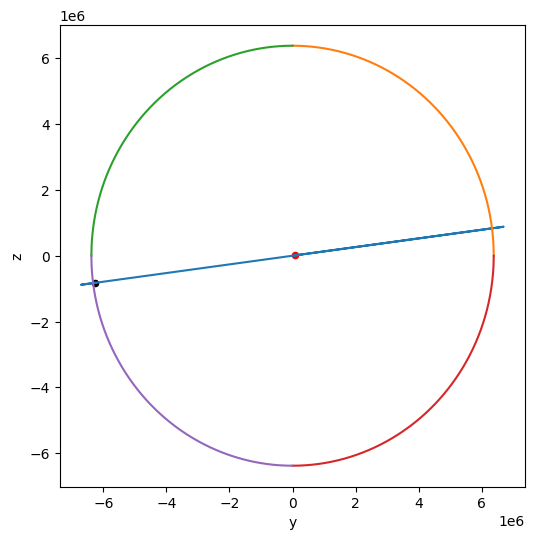

In [524]:
x_axis = np.linspace(0, EARTH_SEMIMAJOR, 1000)
y_axis = np.sqrt(EARTH_SEMIMAJOR**2-x_axis**2)
plt.figure(figsize = (6,6))
plt.plot(xs[:, 1] , xs[:, 2], label = '')
plt.plot(x_axis, y_axis)
plt.plot(-x_axis, y_axis)
plt.plot(x_axis, -y_axis)
plt.plot(-x_axis, -y_axis)
plt.scatter(xs[0, 1] , xs[0, 2], label = 'start', color = 'red', s = 20)
plt.scatter(xs[-1, 1] , xs[-1, 2], label = 'end', color = 'black', s = 20)
# plt.xscale('log', base = 10)
# plt.yscale('log', base = 10)
plt.xlabel('y')
plt.ylabel('z')
plt.title('')
# plt.legend()
# plt.grid()
plt.show()

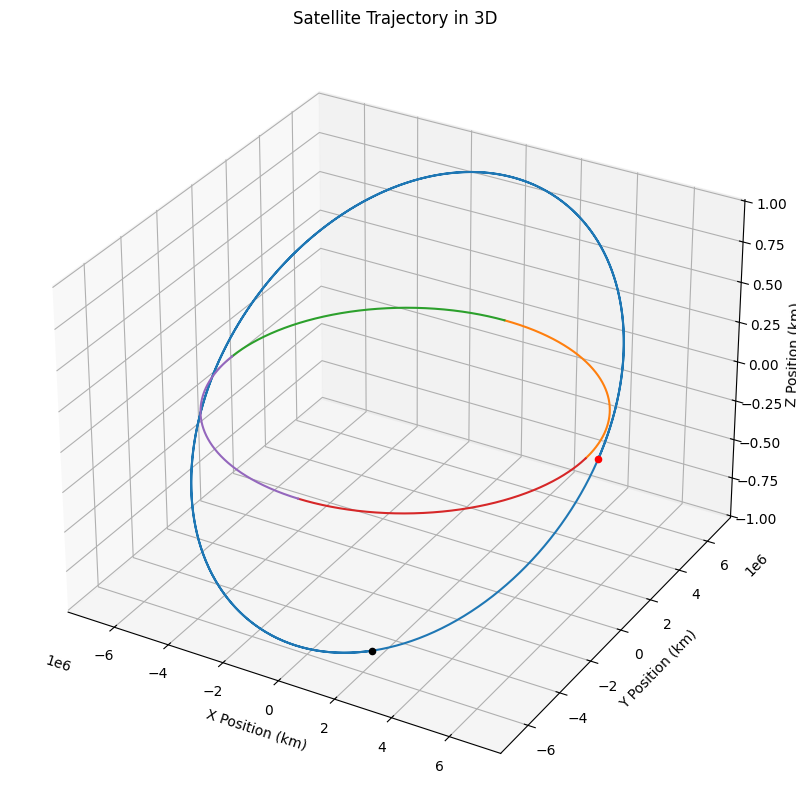

In [525]:
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d')
ax.plot(xs[:, 0] , xs[:, 1], xs[:, 2])
plt.plot(x_axis, y_axis)
plt.plot(-x_axis, y_axis)
plt.plot(x_axis, -y_axis)
plt.plot(-x_axis, -y_axis)
ax.scatter(xs[0, 0] , xs[0, 1], xs[0, 2], label = 'start', color = 'red', s = 20)
ax.scatter(xs[-1, 0] , xs[-1, 1], xs[-1, 2], label = 'end', color = 'black', s = 20)
ax.set_title('Satellite Trajectory in 3D')
ax.set_xlabel('X Position (km)')
ax.set_ylabel('Y Position (km)')
ax.set_zlabel('Z Position (km)')
plt.show()

In [526]:
def ode(t, state_x):
        x, y, z, vx, vy, vz= state_x

        def curvature_in_prime_vertical(phi):
            return EARTH_SEMIMAJOR / np.sqrt(1 - E_SQUARED * np.sin(phi)**2)
        
        def latitude_iterator_and_height(x, y, z):
            r = np.sqrt(x**2 + y**2)
            phi = np.arctan(z / (r * (1 - E_SQUARED)))
            phi_new = phi + 100
            
            while np.abs(phi_new - phi) > 1e-9:
                phi = phi_new
                N = curvature_in_prime_vertical(phi)
                phi_new = np.arctan2(z + (N * E_SQUARED) * np.sin(phi), r - (N * E_SQUARED) * np.cos(phi))
            
            height = (r / np.cos(phi)) - N
            if height < 0:
                height = 0
            
            return phi_new, height
        

        def earth_radius_WGS84(latitude):
            numerator = (EARTH_SEMIMAJOR**2 * np.cos(latitude))**2 + (EARTH_SEMIMINOR**2 * np.sin(latitude))**2
            denominator = (EARTH_SEMIMAJOR * np.cos(latitude))**2 + (EARTH_SEMIMINOR * np.sin(latitude))**2
            return np.sqrt(numerator / denominator)
        
        def lat_long_height(x, y, z):
            r = np.linalg.norm([x,y,z])
            longitude = np.arctan2(z, np.sqrt(x**2 + y**2))
            latitude, height = latitude_iterator_and_height(x, y, z)
            R_earth = earth_radius_WGS84(latitude)
            height = r - R_earth
            return latitude, longitude, height

        def atmospheric_density(altitude):
            # White noise as random perturbations of magnitude 0.1*RHO_0
            density = RHO_0 * np.exp(-altitude / H_SCALE)
            if altitude > 0:
                return density
            else:
                return 0
        
        r = np.linalg.norm(state_x[:3])
        altitude = lat_long_height(x, y, z)[2]

        # Gravity
        F_gravity = -G * M_EARTH / r**2

        # Drag
        rho = atmospheric_density(altitude)
        
        v = np.linalg.norm([vx,vy,vz])

        F_drag_x = -0.5 * rho * CD * A * v * vx / M_SAT
        F_drag_y = -0.5 * rho * CD * A * v * vy / M_SAT
        F_drag_z = -0.5 * rho * CD * A * v * vz / M_SAT
        
        # Acceleration
        ax = F_gravity * (x / r) + F_drag_x
        ay = F_gravity * (y / r) + F_drag_y
        az = F_gravity * (z / r) + F_drag_z

        return np.array([vx, vy, vz, ax, ay, az])


def f(state_x, dt):

    """state vector = state_x = [x,y,z,vx, vy, vz]"""

    if dt <= 10.:
        x, y, z, vx, vy, vz= state_x
        _, _, _, ax, ay, az = ode(0, state_x)
        # Use Euler's method for small dt
        x_new = x + vx * dt
        y_new = y + vy * dt
        z_new = z + vz * dt
        vx_new = vx + ax * dt
        vy_new = vy + ay * dt
        vz_new = vz + az * dt
        return np.array([x_new, y_new, z_new, vx_new, vy_new, vz_new])
    else:
        # Use RK4 for larger dt
        solution = solve_ivp(ode, t_span=[0, dt], y0=state_x, method='RK45', t_eval=[dt])
        # print(solution.y)
        return solution.y.flatten()

In [532]:
"""Initialise satellite, radar and UKF========================"""
# np.random.seed(0)  # for reproducibility
satellite_pos_true = SatelliteTraj(pos=[R_EARTH + 800e3, 0., 0.], vel=[-10., 7600., 1000.], vel_std=0.0)  # true satellite position with noise
radar = RadarStation(radar_pos = (0,0,0), x_std=50000, y_std=50, z_std=10)
ukf = satellite_UKF(fx = f, hx = h_radar, dt=1)

In [544]:
"""Generate radar measurement batches and do batch processing in UKF"""
num_iterations = 50

xs_true = []
xs_prior = []
zs = []
xs = []
Ps = []
ts = [0.0]
### for every iteration, generate num_in_batch measurements, in each batch, the dt are varying according to dt_sim_arr.
### every time we receive a batch, perform batch process using that batch.

time_duration = 0.0 # initialise total time duration of the filtering process
for iter in tqdm(range(num_iterations)):
    num_in_batch = np.random.choice([5, 15, 25])  # random number of measurements in a batch
    dt_sim_arr = np.random.randint(10., 50., num_in_batch) ### randomely generate timesteps
    # zs_batch = []
    for dt_sim in dt_sim_arr:
        time_duration += dt_sim
        sate_pos = np.concatenate(satellite_pos_true.update(dt_sim)).reshape(1,-1).flatten()
        # print(sate_pos)
        xs_true.append(sate_pos)
        ### get radar measurement
        z = np.array(radar.noisy_reading(satellite_pos=sate_pos[:3], time=time_duration))
        # print(z)
        # zs_batch.append(z)
        zs.append(z)
        ts.append(z[3])
        # print(np.array(ts), np.array(ts).shape)
        if np.linalg.norm(sate_pos[:3]) - R_EARTH <=0: break
    print("iteration=", iter, "\tbatch length=", num_in_batch, "\tts=", ts)
    for i, (z, dt) in enumerate(zip(np.array(zs)[-num_in_batch:, :],
                                    np.array(ts)[-num_in_batch:] - np.array(ts)[-num_in_batch-1:-1])):
        ukf.predict(dt=dt)
        xs_prior.append(ukf.x_prior)
        ukf.update(z[:3])
        x_post = ukf.x
        xs.append(x_post)
        x_cov = ukf.P
        Ps.append(x_cov)

xs_true = np.array(xs_true)
xs_prior = np.array(xs_prior)
zs = np.array(zs)
ts = np.array(ts)
# xs = np.concatenate(xs, axis=0)
# Ps = np.concatenate(Ps, axis=0)
xs = np.array(xs)
Ps = np.array(Ps)

  0%|          | 0/50 [00:00<?, ?it/s]

iteration= 0 	batch length= 15 	ts= [0.0, np.float64(18.0), np.float64(47.0), np.float64(77.0), np.float64(111.0), np.float64(130.0), np.float64(166.0), np.float64(193.0), np.float64(233.0), np.float64(271.0), np.float64(319.0), np.float64(367.0), np.float64(402.0), np.float64(437.0), np.float64(466.0), np.float64(515.0)]


  2%|▏         | 1/50 [00:01<00:59,  1.21s/it]

iteration= 1 	batch length= 25 	ts= [0.0, np.float64(18.0), np.float64(47.0), np.float64(77.0), np.float64(111.0), np.float64(130.0), np.float64(166.0), np.float64(193.0), np.float64(233.0), np.float64(271.0), np.float64(319.0), np.float64(367.0), np.float64(402.0), np.float64(437.0), np.float64(466.0), np.float64(515.0), np.float64(551.0), np.float64(579.0), np.float64(596.0), np.float64(610.0), np.float64(645.0), np.float64(684.0), np.float64(716.0), np.float64(729.0), np.float64(748.0), np.float64(789.0), np.float64(806.0), np.float64(853.0), np.float64(892.0), np.float64(940.0), np.float64(988.0), np.float64(1005.0), np.float64(1025.0), np.float64(1051.0), np.float64(1062.0), np.float64(1096.0), np.float64(1114.0), np.float64(1163.0), np.float64(1176.0), np.float64(1207.0), np.float64(1241.0)]


  4%|▍         | 2/50 [00:02<01:12,  1.50s/it]

iteration= 2 	batch length= 5 	ts= [0.0, np.float64(18.0), np.float64(47.0), np.float64(77.0), np.float64(111.0), np.float64(130.0), np.float64(166.0), np.float64(193.0), np.float64(233.0), np.float64(271.0), np.float64(319.0), np.float64(367.0), np.float64(402.0), np.float64(437.0), np.float64(466.0), np.float64(515.0), np.float64(551.0), np.float64(579.0), np.float64(596.0), np.float64(610.0), np.float64(645.0), np.float64(684.0), np.float64(716.0), np.float64(729.0), np.float64(748.0), np.float64(789.0), np.float64(806.0), np.float64(853.0), np.float64(892.0), np.float64(940.0), np.float64(988.0), np.float64(1005.0), np.float64(1025.0), np.float64(1051.0), np.float64(1062.0), np.float64(1096.0), np.float64(1114.0), np.float64(1163.0), np.float64(1176.0), np.float64(1207.0), np.float64(1241.0), np.float64(1290.0), np.float64(1329.0), np.float64(1351.0), np.float64(1395.0), np.float64(1437.0)]


  6%|▌         | 3/50 [00:03<00:45,  1.03it/s]

iteration= 3 	batch length= 5 	ts= [0.0, np.float64(18.0), np.float64(47.0), np.float64(77.0), np.float64(111.0), np.float64(130.0), np.float64(166.0), np.float64(193.0), np.float64(233.0), np.float64(271.0), np.float64(319.0), np.float64(367.0), np.float64(402.0), np.float64(437.0), np.float64(466.0), np.float64(515.0), np.float64(551.0), np.float64(579.0), np.float64(596.0), np.float64(610.0), np.float64(645.0), np.float64(684.0), np.float64(716.0), np.float64(729.0), np.float64(748.0), np.float64(789.0), np.float64(806.0), np.float64(853.0), np.float64(892.0), np.float64(940.0), np.float64(988.0), np.float64(1005.0), np.float64(1025.0), np.float64(1051.0), np.float64(1062.0), np.float64(1096.0), np.float64(1114.0), np.float64(1163.0), np.float64(1176.0), np.float64(1207.0), np.float64(1241.0), np.float64(1290.0), np.float64(1329.0), np.float64(1351.0), np.float64(1395.0), np.float64(1437.0), np.float64(1475.0), np.float64(1491.0), np.float64(1536.0), np.float64(1564.0), np.float64(1

  8%|▊         | 4/50 [00:03<00:32,  1.41it/s]

iteration= 4 	batch length= 15 	ts= [0.0, np.float64(18.0), np.float64(47.0), np.float64(77.0), np.float64(111.0), np.float64(130.0), np.float64(166.0), np.float64(193.0), np.float64(233.0), np.float64(271.0), np.float64(319.0), np.float64(367.0), np.float64(402.0), np.float64(437.0), np.float64(466.0), np.float64(515.0), np.float64(551.0), np.float64(579.0), np.float64(596.0), np.float64(610.0), np.float64(645.0), np.float64(684.0), np.float64(716.0), np.float64(729.0), np.float64(748.0), np.float64(789.0), np.float64(806.0), np.float64(853.0), np.float64(892.0), np.float64(940.0), np.float64(988.0), np.float64(1005.0), np.float64(1025.0), np.float64(1051.0), np.float64(1062.0), np.float64(1096.0), np.float64(1114.0), np.float64(1163.0), np.float64(1176.0), np.float64(1207.0), np.float64(1241.0), np.float64(1290.0), np.float64(1329.0), np.float64(1351.0), np.float64(1395.0), np.float64(1437.0), np.float64(1475.0), np.float64(1491.0), np.float64(1536.0), np.float64(1564.0), np.float64(

 10%|█         | 5/50 [00:04<00:38,  1.18it/s]

iteration= 5 	batch length= 5 	ts= [0.0, np.float64(18.0), np.float64(47.0), np.float64(77.0), np.float64(111.0), np.float64(130.0), np.float64(166.0), np.float64(193.0), np.float64(233.0), np.float64(271.0), np.float64(319.0), np.float64(367.0), np.float64(402.0), np.float64(437.0), np.float64(466.0), np.float64(515.0), np.float64(551.0), np.float64(579.0), np.float64(596.0), np.float64(610.0), np.float64(645.0), np.float64(684.0), np.float64(716.0), np.float64(729.0), np.float64(748.0), np.float64(789.0), np.float64(806.0), np.float64(853.0), np.float64(892.0), np.float64(940.0), np.float64(988.0), np.float64(1005.0), np.float64(1025.0), np.float64(1051.0), np.float64(1062.0), np.float64(1096.0), np.float64(1114.0), np.float64(1163.0), np.float64(1176.0), np.float64(1207.0), np.float64(1241.0), np.float64(1290.0), np.float64(1329.0), np.float64(1351.0), np.float64(1395.0), np.float64(1437.0), np.float64(1475.0), np.float64(1491.0), np.float64(1536.0), np.float64(1564.0), np.float64(1

 12%|█▏        | 6/50 [00:05<00:29,  1.48it/s]

iteration= 6 	batch length= 5 	ts= [0.0, np.float64(18.0), np.float64(47.0), np.float64(77.0), np.float64(111.0), np.float64(130.0), np.float64(166.0), np.float64(193.0), np.float64(233.0), np.float64(271.0), np.float64(319.0), np.float64(367.0), np.float64(402.0), np.float64(437.0), np.float64(466.0), np.float64(515.0), np.float64(551.0), np.float64(579.0), np.float64(596.0), np.float64(610.0), np.float64(645.0), np.float64(684.0), np.float64(716.0), np.float64(729.0), np.float64(748.0), np.float64(789.0), np.float64(806.0), np.float64(853.0), np.float64(892.0), np.float64(940.0), np.float64(988.0), np.float64(1005.0), np.float64(1025.0), np.float64(1051.0), np.float64(1062.0), np.float64(1096.0), np.float64(1114.0), np.float64(1163.0), np.float64(1176.0), np.float64(1207.0), np.float64(1241.0), np.float64(1290.0), np.float64(1329.0), np.float64(1351.0), np.float64(1395.0), np.float64(1437.0), np.float64(1475.0), np.float64(1491.0), np.float64(1536.0), np.float64(1564.0), np.float64(1

 14%|█▍        | 7/50 [00:05<00:24,  1.75it/s]

iteration= 7 	batch length= 15 	ts= [0.0, np.float64(18.0), np.float64(47.0), np.float64(77.0), np.float64(111.0), np.float64(130.0), np.float64(166.0), np.float64(193.0), np.float64(233.0), np.float64(271.0), np.float64(319.0), np.float64(367.0), np.float64(402.0), np.float64(437.0), np.float64(466.0), np.float64(515.0), np.float64(551.0), np.float64(579.0), np.float64(596.0), np.float64(610.0), np.float64(645.0), np.float64(684.0), np.float64(716.0), np.float64(729.0), np.float64(748.0), np.float64(789.0), np.float64(806.0), np.float64(853.0), np.float64(892.0), np.float64(940.0), np.float64(988.0), np.float64(1005.0), np.float64(1025.0), np.float64(1051.0), np.float64(1062.0), np.float64(1096.0), np.float64(1114.0), np.float64(1163.0), np.float64(1176.0), np.float64(1207.0), np.float64(1241.0), np.float64(1290.0), np.float64(1329.0), np.float64(1351.0), np.float64(1395.0), np.float64(1437.0), np.float64(1475.0), np.float64(1491.0), np.float64(1536.0), np.float64(1564.0), np.float64(

 16%|█▌        | 8/50 [00:06<00:30,  1.39it/s]

iteration= 8 	batch length= 25 	ts= [0.0, np.float64(18.0), np.float64(47.0), np.float64(77.0), np.float64(111.0), np.float64(130.0), np.float64(166.0), np.float64(193.0), np.float64(233.0), np.float64(271.0), np.float64(319.0), np.float64(367.0), np.float64(402.0), np.float64(437.0), np.float64(466.0), np.float64(515.0), np.float64(551.0), np.float64(579.0), np.float64(596.0), np.float64(610.0), np.float64(645.0), np.float64(684.0), np.float64(716.0), np.float64(729.0), np.float64(748.0), np.float64(789.0), np.float64(806.0), np.float64(853.0), np.float64(892.0), np.float64(940.0), np.float64(988.0), np.float64(1005.0), np.float64(1025.0), np.float64(1051.0), np.float64(1062.0), np.float64(1096.0), np.float64(1114.0), np.float64(1163.0), np.float64(1176.0), np.float64(1207.0), np.float64(1241.0), np.float64(1290.0), np.float64(1329.0), np.float64(1351.0), np.float64(1395.0), np.float64(1437.0), np.float64(1475.0), np.float64(1491.0), np.float64(1536.0), np.float64(1564.0), np.float64(

 18%|█▊        | 9/50 [00:08<00:42,  1.04s/it]

iteration= 9 	batch length= 15 	ts= [0.0, np.float64(18.0), np.float64(47.0), np.float64(77.0), np.float64(111.0), np.float64(130.0), np.float64(166.0), np.float64(193.0), np.float64(233.0), np.float64(271.0), np.float64(319.0), np.float64(367.0), np.float64(402.0), np.float64(437.0), np.float64(466.0), np.float64(515.0), np.float64(551.0), np.float64(579.0), np.float64(596.0), np.float64(610.0), np.float64(645.0), np.float64(684.0), np.float64(716.0), np.float64(729.0), np.float64(748.0), np.float64(789.0), np.float64(806.0), np.float64(853.0), np.float64(892.0), np.float64(940.0), np.float64(988.0), np.float64(1005.0), np.float64(1025.0), np.float64(1051.0), np.float64(1062.0), np.float64(1096.0), np.float64(1114.0), np.float64(1163.0), np.float64(1176.0), np.float64(1207.0), np.float64(1241.0), np.float64(1290.0), np.float64(1329.0), np.float64(1351.0), np.float64(1395.0), np.float64(1437.0), np.float64(1475.0), np.float64(1491.0), np.float64(1536.0), np.float64(1564.0), np.float64(

 20%|██        | 10/50 [00:09<00:41,  1.03s/it]

iteration= 10 	batch length= 5 	ts= [0.0, np.float64(18.0), np.float64(47.0), np.float64(77.0), np.float64(111.0), np.float64(130.0), np.float64(166.0), np.float64(193.0), np.float64(233.0), np.float64(271.0), np.float64(319.0), np.float64(367.0), np.float64(402.0), np.float64(437.0), np.float64(466.0), np.float64(515.0), np.float64(551.0), np.float64(579.0), np.float64(596.0), np.float64(610.0), np.float64(645.0), np.float64(684.0), np.float64(716.0), np.float64(729.0), np.float64(748.0), np.float64(789.0), np.float64(806.0), np.float64(853.0), np.float64(892.0), np.float64(940.0), np.float64(988.0), np.float64(1005.0), np.float64(1025.0), np.float64(1051.0), np.float64(1062.0), np.float64(1096.0), np.float64(1114.0), np.float64(1163.0), np.float64(1176.0), np.float64(1207.0), np.float64(1241.0), np.float64(1290.0), np.float64(1329.0), np.float64(1351.0), np.float64(1395.0), np.float64(1437.0), np.float64(1475.0), np.float64(1491.0), np.float64(1536.0), np.float64(1564.0), np.float64(

 22%|██▏       | 11/50 [00:09<00:31,  1.23it/s]

iteration= 11 	batch length= 15 	ts= [0.0, np.float64(18.0), np.float64(47.0), np.float64(77.0), np.float64(111.0), np.float64(130.0), np.float64(166.0), np.float64(193.0), np.float64(233.0), np.float64(271.0), np.float64(319.0), np.float64(367.0), np.float64(402.0), np.float64(437.0), np.float64(466.0), np.float64(515.0), np.float64(551.0), np.float64(579.0), np.float64(596.0), np.float64(610.0), np.float64(645.0), np.float64(684.0), np.float64(716.0), np.float64(729.0), np.float64(748.0), np.float64(789.0), np.float64(806.0), np.float64(853.0), np.float64(892.0), np.float64(940.0), np.float64(988.0), np.float64(1005.0), np.float64(1025.0), np.float64(1051.0), np.float64(1062.0), np.float64(1096.0), np.float64(1114.0), np.float64(1163.0), np.float64(1176.0), np.float64(1207.0), np.float64(1241.0), np.float64(1290.0), np.float64(1329.0), np.float64(1351.0), np.float64(1395.0), np.float64(1437.0), np.float64(1475.0), np.float64(1491.0), np.float64(1536.0), np.float64(1564.0), np.float64

 24%|██▍       | 12/50 [00:10<00:32,  1.18it/s]

iteration= 12 	batch length= 25 	ts= [0.0, np.float64(18.0), np.float64(47.0), np.float64(77.0), np.float64(111.0), np.float64(130.0), np.float64(166.0), np.float64(193.0), np.float64(233.0), np.float64(271.0), np.float64(319.0), np.float64(367.0), np.float64(402.0), np.float64(437.0), np.float64(466.0), np.float64(515.0), np.float64(551.0), np.float64(579.0), np.float64(596.0), np.float64(610.0), np.float64(645.0), np.float64(684.0), np.float64(716.0), np.float64(729.0), np.float64(748.0), np.float64(789.0), np.float64(806.0), np.float64(853.0), np.float64(892.0), np.float64(940.0), np.float64(988.0), np.float64(1005.0), np.float64(1025.0), np.float64(1051.0), np.float64(1062.0), np.float64(1096.0), np.float64(1114.0), np.float64(1163.0), np.float64(1176.0), np.float64(1207.0), np.float64(1241.0), np.float64(1290.0), np.float64(1329.0), np.float64(1351.0), np.float64(1395.0), np.float64(1437.0), np.float64(1475.0), np.float64(1491.0), np.float64(1536.0), np.float64(1564.0), np.float64

 26%|██▌       | 13/50 [00:12<00:40,  1.09s/it]

iteration= 13 	batch length= 5 	ts= [0.0, np.float64(18.0), np.float64(47.0), np.float64(77.0), np.float64(111.0), np.float64(130.0), np.float64(166.0), np.float64(193.0), np.float64(233.0), np.float64(271.0), np.float64(319.0), np.float64(367.0), np.float64(402.0), np.float64(437.0), np.float64(466.0), np.float64(515.0), np.float64(551.0), np.float64(579.0), np.float64(596.0), np.float64(610.0), np.float64(645.0), np.float64(684.0), np.float64(716.0), np.float64(729.0), np.float64(748.0), np.float64(789.0), np.float64(806.0), np.float64(853.0), np.float64(892.0), np.float64(940.0), np.float64(988.0), np.float64(1005.0), np.float64(1025.0), np.float64(1051.0), np.float64(1062.0), np.float64(1096.0), np.float64(1114.0), np.float64(1163.0), np.float64(1176.0), np.float64(1207.0), np.float64(1241.0), np.float64(1290.0), np.float64(1329.0), np.float64(1351.0), np.float64(1395.0), np.float64(1437.0), np.float64(1475.0), np.float64(1491.0), np.float64(1536.0), np.float64(1564.0), np.float64(

 28%|██▊       | 14/50 [00:12<00:30,  1.18it/s]

iteration= 14 	batch length= 15 	ts= [0.0, np.float64(18.0), np.float64(47.0), np.float64(77.0), np.float64(111.0), np.float64(130.0), np.float64(166.0), np.float64(193.0), np.float64(233.0), np.float64(271.0), np.float64(319.0), np.float64(367.0), np.float64(402.0), np.float64(437.0), np.float64(466.0), np.float64(515.0), np.float64(551.0), np.float64(579.0), np.float64(596.0), np.float64(610.0), np.float64(645.0), np.float64(684.0), np.float64(716.0), np.float64(729.0), np.float64(748.0), np.float64(789.0), np.float64(806.0), np.float64(853.0), np.float64(892.0), np.float64(940.0), np.float64(988.0), np.float64(1005.0), np.float64(1025.0), np.float64(1051.0), np.float64(1062.0), np.float64(1096.0), np.float64(1114.0), np.float64(1163.0), np.float64(1176.0), np.float64(1207.0), np.float64(1241.0), np.float64(1290.0), np.float64(1329.0), np.float64(1351.0), np.float64(1395.0), np.float64(1437.0), np.float64(1475.0), np.float64(1491.0), np.float64(1536.0), np.float64(1564.0), np.float64

 30%|███       | 15/50 [00:13<00:30,  1.16it/s]

iteration= 15 	batch length= 15 	ts= [0.0, np.float64(18.0), np.float64(47.0), np.float64(77.0), np.float64(111.0), np.float64(130.0), np.float64(166.0), np.float64(193.0), np.float64(233.0), np.float64(271.0), np.float64(319.0), np.float64(367.0), np.float64(402.0), np.float64(437.0), np.float64(466.0), np.float64(515.0), np.float64(551.0), np.float64(579.0), np.float64(596.0), np.float64(610.0), np.float64(645.0), np.float64(684.0), np.float64(716.0), np.float64(729.0), np.float64(748.0), np.float64(789.0), np.float64(806.0), np.float64(853.0), np.float64(892.0), np.float64(940.0), np.float64(988.0), np.float64(1005.0), np.float64(1025.0), np.float64(1051.0), np.float64(1062.0), np.float64(1096.0), np.float64(1114.0), np.float64(1163.0), np.float64(1176.0), np.float64(1207.0), np.float64(1241.0), np.float64(1290.0), np.float64(1329.0), np.float64(1351.0), np.float64(1395.0), np.float64(1437.0), np.float64(1475.0), np.float64(1491.0), np.float64(1536.0), np.float64(1564.0), np.float64

 32%|███▏      | 16/50 [00:14<00:30,  1.13it/s]

iteration= 16 	batch length= 15 	ts= [0.0, np.float64(18.0), np.float64(47.0), np.float64(77.0), np.float64(111.0), np.float64(130.0), np.float64(166.0), np.float64(193.0), np.float64(233.0), np.float64(271.0), np.float64(319.0), np.float64(367.0), np.float64(402.0), np.float64(437.0), np.float64(466.0), np.float64(515.0), np.float64(551.0), np.float64(579.0), np.float64(596.0), np.float64(610.0), np.float64(645.0), np.float64(684.0), np.float64(716.0), np.float64(729.0), np.float64(748.0), np.float64(789.0), np.float64(806.0), np.float64(853.0), np.float64(892.0), np.float64(940.0), np.float64(988.0), np.float64(1005.0), np.float64(1025.0), np.float64(1051.0), np.float64(1062.0), np.float64(1096.0), np.float64(1114.0), np.float64(1163.0), np.float64(1176.0), np.float64(1207.0), np.float64(1241.0), np.float64(1290.0), np.float64(1329.0), np.float64(1351.0), np.float64(1395.0), np.float64(1437.0), np.float64(1475.0), np.float64(1491.0), np.float64(1536.0), np.float64(1564.0), np.float64

 34%|███▍      | 17/50 [00:15<00:30,  1.09it/s]

iteration= 17 	batch length= 25 	ts= [0.0, np.float64(18.0), np.float64(47.0), np.float64(77.0), np.float64(111.0), np.float64(130.0), np.float64(166.0), np.float64(193.0), np.float64(233.0), np.float64(271.0), np.float64(319.0), np.float64(367.0), np.float64(402.0), np.float64(437.0), np.float64(466.0), np.float64(515.0), np.float64(551.0), np.float64(579.0), np.float64(596.0), np.float64(610.0), np.float64(645.0), np.float64(684.0), np.float64(716.0), np.float64(729.0), np.float64(748.0), np.float64(789.0), np.float64(806.0), np.float64(853.0), np.float64(892.0), np.float64(940.0), np.float64(988.0), np.float64(1005.0), np.float64(1025.0), np.float64(1051.0), np.float64(1062.0), np.float64(1096.0), np.float64(1114.0), np.float64(1163.0), np.float64(1176.0), np.float64(1207.0), np.float64(1241.0), np.float64(1290.0), np.float64(1329.0), np.float64(1351.0), np.float64(1395.0), np.float64(1437.0), np.float64(1475.0), np.float64(1491.0), np.float64(1536.0), np.float64(1564.0), np.float64

 36%|███▌      | 18/50 [00:16<00:35,  1.10s/it]

iteration= 18 	batch length= 5 	ts= [0.0, np.float64(18.0), np.float64(47.0), np.float64(77.0), np.float64(111.0), np.float64(130.0), np.float64(166.0), np.float64(193.0), np.float64(233.0), np.float64(271.0), np.float64(319.0), np.float64(367.0), np.float64(402.0), np.float64(437.0), np.float64(466.0), np.float64(515.0), np.float64(551.0), np.float64(579.0), np.float64(596.0), np.float64(610.0), np.float64(645.0), np.float64(684.0), np.float64(716.0), np.float64(729.0), np.float64(748.0), np.float64(789.0), np.float64(806.0), np.float64(853.0), np.float64(892.0), np.float64(940.0), np.float64(988.0), np.float64(1005.0), np.float64(1025.0), np.float64(1051.0), np.float64(1062.0), np.float64(1096.0), np.float64(1114.0), np.float64(1163.0), np.float64(1176.0), np.float64(1207.0), np.float64(1241.0), np.float64(1290.0), np.float64(1329.0), np.float64(1351.0), np.float64(1395.0), np.float64(1437.0), np.float64(1475.0), np.float64(1491.0), np.float64(1536.0), np.float64(1564.0), np.float64(

 38%|███▊      | 19/50 [00:17<00:27,  1.13it/s]

iteration= 19 	batch length= 25 	ts= [0.0, np.float64(18.0), np.float64(47.0), np.float64(77.0), np.float64(111.0), np.float64(130.0), np.float64(166.0), np.float64(193.0), np.float64(233.0), np.float64(271.0), np.float64(319.0), np.float64(367.0), np.float64(402.0), np.float64(437.0), np.float64(466.0), np.float64(515.0), np.float64(551.0), np.float64(579.0), np.float64(596.0), np.float64(610.0), np.float64(645.0), np.float64(684.0), np.float64(716.0), np.float64(729.0), np.float64(748.0), np.float64(789.0), np.float64(806.0), np.float64(853.0), np.float64(892.0), np.float64(940.0), np.float64(988.0), np.float64(1005.0), np.float64(1025.0), np.float64(1051.0), np.float64(1062.0), np.float64(1096.0), np.float64(1114.0), np.float64(1163.0), np.float64(1176.0), np.float64(1207.0), np.float64(1241.0), np.float64(1290.0), np.float64(1329.0), np.float64(1351.0), np.float64(1395.0), np.float64(1437.0), np.float64(1475.0), np.float64(1491.0), np.float64(1536.0), np.float64(1564.0), np.float64

 40%|████      | 20/50 [00:18<00:33,  1.12s/it]

iteration= 20 	batch length= 25 	ts= [0.0, np.float64(18.0), np.float64(47.0), np.float64(77.0), np.float64(111.0), np.float64(130.0), np.float64(166.0), np.float64(193.0), np.float64(233.0), np.float64(271.0), np.float64(319.0), np.float64(367.0), np.float64(402.0), np.float64(437.0), np.float64(466.0), np.float64(515.0), np.float64(551.0), np.float64(579.0), np.float64(596.0), np.float64(610.0), np.float64(645.0), np.float64(684.0), np.float64(716.0), np.float64(729.0), np.float64(748.0), np.float64(789.0), np.float64(806.0), np.float64(853.0), np.float64(892.0), np.float64(940.0), np.float64(988.0), np.float64(1005.0), np.float64(1025.0), np.float64(1051.0), np.float64(1062.0), np.float64(1096.0), np.float64(1114.0), np.float64(1163.0), np.float64(1176.0), np.float64(1207.0), np.float64(1241.0), np.float64(1290.0), np.float64(1329.0), np.float64(1351.0), np.float64(1395.0), np.float64(1437.0), np.float64(1475.0), np.float64(1491.0), np.float64(1536.0), np.float64(1564.0), np.float64

 42%|████▏     | 21/50 [00:20<00:37,  1.30s/it]

iteration= 21 	batch length= 25 	ts= [0.0, np.float64(18.0), np.float64(47.0), np.float64(77.0), np.float64(111.0), np.float64(130.0), np.float64(166.0), np.float64(193.0), np.float64(233.0), np.float64(271.0), np.float64(319.0), np.float64(367.0), np.float64(402.0), np.float64(437.0), np.float64(466.0), np.float64(515.0), np.float64(551.0), np.float64(579.0), np.float64(596.0), np.float64(610.0), np.float64(645.0), np.float64(684.0), np.float64(716.0), np.float64(729.0), np.float64(748.0), np.float64(789.0), np.float64(806.0), np.float64(853.0), np.float64(892.0), np.float64(940.0), np.float64(988.0), np.float64(1005.0), np.float64(1025.0), np.float64(1051.0), np.float64(1062.0), np.float64(1096.0), np.float64(1114.0), np.float64(1163.0), np.float64(1176.0), np.float64(1207.0), np.float64(1241.0), np.float64(1290.0), np.float64(1329.0), np.float64(1351.0), np.float64(1395.0), np.float64(1437.0), np.float64(1475.0), np.float64(1491.0), np.float64(1536.0), np.float64(1564.0), np.float64

 44%|████▍     | 22/50 [00:22<00:39,  1.42s/it]

iteration= 22 	batch length= 5 	ts= [0.0, np.float64(18.0), np.float64(47.0), np.float64(77.0), np.float64(111.0), np.float64(130.0), np.float64(166.0), np.float64(193.0), np.float64(233.0), np.float64(271.0), np.float64(319.0), np.float64(367.0), np.float64(402.0), np.float64(437.0), np.float64(466.0), np.float64(515.0), np.float64(551.0), np.float64(579.0), np.float64(596.0), np.float64(610.0), np.float64(645.0), np.float64(684.0), np.float64(716.0), np.float64(729.0), np.float64(748.0), np.float64(789.0), np.float64(806.0), np.float64(853.0), np.float64(892.0), np.float64(940.0), np.float64(988.0), np.float64(1005.0), np.float64(1025.0), np.float64(1051.0), np.float64(1062.0), np.float64(1096.0), np.float64(1114.0), np.float64(1163.0), np.float64(1176.0), np.float64(1207.0), np.float64(1241.0), np.float64(1290.0), np.float64(1329.0), np.float64(1351.0), np.float64(1395.0), np.float64(1437.0), np.float64(1475.0), np.float64(1491.0), np.float64(1536.0), np.float64(1564.0), np.float64(

 46%|████▌     | 23/50 [00:22<00:29,  1.09s/it]

iteration= 23 	batch length= 25 	ts= [0.0, np.float64(18.0), np.float64(47.0), np.float64(77.0), np.float64(111.0), np.float64(130.0), np.float64(166.0), np.float64(193.0), np.float64(233.0), np.float64(271.0), np.float64(319.0), np.float64(367.0), np.float64(402.0), np.float64(437.0), np.float64(466.0), np.float64(515.0), np.float64(551.0), np.float64(579.0), np.float64(596.0), np.float64(610.0), np.float64(645.0), np.float64(684.0), np.float64(716.0), np.float64(729.0), np.float64(748.0), np.float64(789.0), np.float64(806.0), np.float64(853.0), np.float64(892.0), np.float64(940.0), np.float64(988.0), np.float64(1005.0), np.float64(1025.0), np.float64(1051.0), np.float64(1062.0), np.float64(1096.0), np.float64(1114.0), np.float64(1163.0), np.float64(1176.0), np.float64(1207.0), np.float64(1241.0), np.float64(1290.0), np.float64(1329.0), np.float64(1351.0), np.float64(1395.0), np.float64(1437.0), np.float64(1475.0), np.float64(1491.0), np.float64(1536.0), np.float64(1564.0), np.float64

 48%|████▊     | 24/50 [00:24<00:32,  1.23s/it]

iteration= 24 	batch length= 25 	ts= [0.0, np.float64(18.0), np.float64(47.0), np.float64(77.0), np.float64(111.0), np.float64(130.0), np.float64(166.0), np.float64(193.0), np.float64(233.0), np.float64(271.0), np.float64(319.0), np.float64(367.0), np.float64(402.0), np.float64(437.0), np.float64(466.0), np.float64(515.0), np.float64(551.0), np.float64(579.0), np.float64(596.0), np.float64(610.0), np.float64(645.0), np.float64(684.0), np.float64(716.0), np.float64(729.0), np.float64(748.0), np.float64(789.0), np.float64(806.0), np.float64(853.0), np.float64(892.0), np.float64(940.0), np.float64(988.0), np.float64(1005.0), np.float64(1025.0), np.float64(1051.0), np.float64(1062.0), np.float64(1096.0), np.float64(1114.0), np.float64(1163.0), np.float64(1176.0), np.float64(1207.0), np.float64(1241.0), np.float64(1290.0), np.float64(1329.0), np.float64(1351.0), np.float64(1395.0), np.float64(1437.0), np.float64(1475.0), np.float64(1491.0), np.float64(1536.0), np.float64(1564.0), np.float64

 50%|█████     | 25/50 [00:25<00:33,  1.36s/it]

iteration= 25 	batch length= 25 	ts= [0.0, np.float64(18.0), np.float64(47.0), np.float64(77.0), np.float64(111.0), np.float64(130.0), np.float64(166.0), np.float64(193.0), np.float64(233.0), np.float64(271.0), np.float64(319.0), np.float64(367.0), np.float64(402.0), np.float64(437.0), np.float64(466.0), np.float64(515.0), np.float64(551.0), np.float64(579.0), np.float64(596.0), np.float64(610.0), np.float64(645.0), np.float64(684.0), np.float64(716.0), np.float64(729.0), np.float64(748.0), np.float64(789.0), np.float64(806.0), np.float64(853.0), np.float64(892.0), np.float64(940.0), np.float64(988.0), np.float64(1005.0), np.float64(1025.0), np.float64(1051.0), np.float64(1062.0), np.float64(1096.0), np.float64(1114.0), np.float64(1163.0), np.float64(1176.0), np.float64(1207.0), np.float64(1241.0), np.float64(1290.0), np.float64(1329.0), np.float64(1351.0), np.float64(1395.0), np.float64(1437.0), np.float64(1475.0), np.float64(1491.0), np.float64(1536.0), np.float64(1564.0), np.float64

 52%|█████▏    | 26/50 [00:27<00:34,  1.45s/it]

iteration= 26 	batch length= 5 	ts= [0.0, np.float64(18.0), np.float64(47.0), np.float64(77.0), np.float64(111.0), np.float64(130.0), np.float64(166.0), np.float64(193.0), np.float64(233.0), np.float64(271.0), np.float64(319.0), np.float64(367.0), np.float64(402.0), np.float64(437.0), np.float64(466.0), np.float64(515.0), np.float64(551.0), np.float64(579.0), np.float64(596.0), np.float64(610.0), np.float64(645.0), np.float64(684.0), np.float64(716.0), np.float64(729.0), np.float64(748.0), np.float64(789.0), np.float64(806.0), np.float64(853.0), np.float64(892.0), np.float64(940.0), np.float64(988.0), np.float64(1005.0), np.float64(1025.0), np.float64(1051.0), np.float64(1062.0), np.float64(1096.0), np.float64(1114.0), np.float64(1163.0), np.float64(1176.0), np.float64(1207.0), np.float64(1241.0), np.float64(1290.0), np.float64(1329.0), np.float64(1351.0), np.float64(1395.0), np.float64(1437.0), np.float64(1475.0), np.float64(1491.0), np.float64(1536.0), np.float64(1564.0), np.float64(

 54%|█████▍    | 27/50 [00:27<00:25,  1.11s/it]

iteration= 27 	batch length= 15 	ts= [0.0, np.float64(18.0), np.float64(47.0), np.float64(77.0), np.float64(111.0), np.float64(130.0), np.float64(166.0), np.float64(193.0), np.float64(233.0), np.float64(271.0), np.float64(319.0), np.float64(367.0), np.float64(402.0), np.float64(437.0), np.float64(466.0), np.float64(515.0), np.float64(551.0), np.float64(579.0), np.float64(596.0), np.float64(610.0), np.float64(645.0), np.float64(684.0), np.float64(716.0), np.float64(729.0), np.float64(748.0), np.float64(789.0), np.float64(806.0), np.float64(853.0), np.float64(892.0), np.float64(940.0), np.float64(988.0), np.float64(1005.0), np.float64(1025.0), np.float64(1051.0), np.float64(1062.0), np.float64(1096.0), np.float64(1114.0), np.float64(1163.0), np.float64(1176.0), np.float64(1207.0), np.float64(1241.0), np.float64(1290.0), np.float64(1329.0), np.float64(1351.0), np.float64(1395.0), np.float64(1437.0), np.float64(1475.0), np.float64(1491.0), np.float64(1536.0), np.float64(1564.0), np.float64

 56%|█████▌    | 28/50 [00:28<00:22,  1.04s/it]

iteration= 28 	batch length= 15 	ts= [0.0, np.float64(18.0), np.float64(47.0), np.float64(77.0), np.float64(111.0), np.float64(130.0), np.float64(166.0), np.float64(193.0), np.float64(233.0), np.float64(271.0), np.float64(319.0), np.float64(367.0), np.float64(402.0), np.float64(437.0), np.float64(466.0), np.float64(515.0), np.float64(551.0), np.float64(579.0), np.float64(596.0), np.float64(610.0), np.float64(645.0), np.float64(684.0), np.float64(716.0), np.float64(729.0), np.float64(748.0), np.float64(789.0), np.float64(806.0), np.float64(853.0), np.float64(892.0), np.float64(940.0), np.float64(988.0), np.float64(1005.0), np.float64(1025.0), np.float64(1051.0), np.float64(1062.0), np.float64(1096.0), np.float64(1114.0), np.float64(1163.0), np.float64(1176.0), np.float64(1207.0), np.float64(1241.0), np.float64(1290.0), np.float64(1329.0), np.float64(1351.0), np.float64(1395.0), np.float64(1437.0), np.float64(1475.0), np.float64(1491.0), np.float64(1536.0), np.float64(1564.0), np.float64

 58%|█████▊    | 29/50 [00:29<00:21,  1.01s/it]

iteration= 29 	batch length= 5 	ts= [0.0, np.float64(18.0), np.float64(47.0), np.float64(77.0), np.float64(111.0), np.float64(130.0), np.float64(166.0), np.float64(193.0), np.float64(233.0), np.float64(271.0), np.float64(319.0), np.float64(367.0), np.float64(402.0), np.float64(437.0), np.float64(466.0), np.float64(515.0), np.float64(551.0), np.float64(579.0), np.float64(596.0), np.float64(610.0), np.float64(645.0), np.float64(684.0), np.float64(716.0), np.float64(729.0), np.float64(748.0), np.float64(789.0), np.float64(806.0), np.float64(853.0), np.float64(892.0), np.float64(940.0), np.float64(988.0), np.float64(1005.0), np.float64(1025.0), np.float64(1051.0), np.float64(1062.0), np.float64(1096.0), np.float64(1114.0), np.float64(1163.0), np.float64(1176.0), np.float64(1207.0), np.float64(1241.0), np.float64(1290.0), np.float64(1329.0), np.float64(1351.0), np.float64(1395.0), np.float64(1437.0), np.float64(1475.0), np.float64(1491.0), np.float64(1536.0), np.float64(1564.0), np.float64(

 60%|██████    | 30/50 [00:29<00:15,  1.27it/s]

iteration= 30 	batch length= 15 	ts= [0.0, np.float64(18.0), np.float64(47.0), np.float64(77.0), np.float64(111.0), np.float64(130.0), np.float64(166.0), np.float64(193.0), np.float64(233.0), np.float64(271.0), np.float64(319.0), np.float64(367.0), np.float64(402.0), np.float64(437.0), np.float64(466.0), np.float64(515.0), np.float64(551.0), np.float64(579.0), np.float64(596.0), np.float64(610.0), np.float64(645.0), np.float64(684.0), np.float64(716.0), np.float64(729.0), np.float64(748.0), np.float64(789.0), np.float64(806.0), np.float64(853.0), np.float64(892.0), np.float64(940.0), np.float64(988.0), np.float64(1005.0), np.float64(1025.0), np.float64(1051.0), np.float64(1062.0), np.float64(1096.0), np.float64(1114.0), np.float64(1163.0), np.float64(1176.0), np.float64(1207.0), np.float64(1241.0), np.float64(1290.0), np.float64(1329.0), np.float64(1351.0), np.float64(1395.0), np.float64(1437.0), np.float64(1475.0), np.float64(1491.0), np.float64(1536.0), np.float64(1564.0), np.float64

 62%|██████▏   | 31/50 [00:30<00:15,  1.19it/s]

iteration= 31 	batch length= 15 	ts= [0.0, np.float64(18.0), np.float64(47.0), np.float64(77.0), np.float64(111.0), np.float64(130.0), np.float64(166.0), np.float64(193.0), np.float64(233.0), np.float64(271.0), np.float64(319.0), np.float64(367.0), np.float64(402.0), np.float64(437.0), np.float64(466.0), np.float64(515.0), np.float64(551.0), np.float64(579.0), np.float64(596.0), np.float64(610.0), np.float64(645.0), np.float64(684.0), np.float64(716.0), np.float64(729.0), np.float64(748.0), np.float64(789.0), np.float64(806.0), np.float64(853.0), np.float64(892.0), np.float64(940.0), np.float64(988.0), np.float64(1005.0), np.float64(1025.0), np.float64(1051.0), np.float64(1062.0), np.float64(1096.0), np.float64(1114.0), np.float64(1163.0), np.float64(1176.0), np.float64(1207.0), np.float64(1241.0), np.float64(1290.0), np.float64(1329.0), np.float64(1351.0), np.float64(1395.0), np.float64(1437.0), np.float64(1475.0), np.float64(1491.0), np.float64(1536.0), np.float64(1564.0), np.float64

 64%|██████▍   | 32/50 [00:31<00:15,  1.17it/s]

iteration= 32 	batch length= 5 	ts= [0.0, np.float64(18.0), np.float64(47.0), np.float64(77.0), np.float64(111.0), np.float64(130.0), np.float64(166.0), np.float64(193.0), np.float64(233.0), np.float64(271.0), np.float64(319.0), np.float64(367.0), np.float64(402.0), np.float64(437.0), np.float64(466.0), np.float64(515.0), np.float64(551.0), np.float64(579.0), np.float64(596.0), np.float64(610.0), np.float64(645.0), np.float64(684.0), np.float64(716.0), np.float64(729.0), np.float64(748.0), np.float64(789.0), np.float64(806.0), np.float64(853.0), np.float64(892.0), np.float64(940.0), np.float64(988.0), np.float64(1005.0), np.float64(1025.0), np.float64(1051.0), np.float64(1062.0), np.float64(1096.0), np.float64(1114.0), np.float64(1163.0), np.float64(1176.0), np.float64(1207.0), np.float64(1241.0), np.float64(1290.0), np.float64(1329.0), np.float64(1351.0), np.float64(1395.0), np.float64(1437.0), np.float64(1475.0), np.float64(1491.0), np.float64(1536.0), np.float64(1564.0), np.float64(

 66%|██████▌   | 33/50 [00:31<00:11,  1.42it/s]

iteration= 33 	batch length= 5 	ts= [0.0, np.float64(18.0), np.float64(47.0), np.float64(77.0), np.float64(111.0), np.float64(130.0), np.float64(166.0), np.float64(193.0), np.float64(233.0), np.float64(271.0), np.float64(319.0), np.float64(367.0), np.float64(402.0), np.float64(437.0), np.float64(466.0), np.float64(515.0), np.float64(551.0), np.float64(579.0), np.float64(596.0), np.float64(610.0), np.float64(645.0), np.float64(684.0), np.float64(716.0), np.float64(729.0), np.float64(748.0), np.float64(789.0), np.float64(806.0), np.float64(853.0), np.float64(892.0), np.float64(940.0), np.float64(988.0), np.float64(1005.0), np.float64(1025.0), np.float64(1051.0), np.float64(1062.0), np.float64(1096.0), np.float64(1114.0), np.float64(1163.0), np.float64(1176.0), np.float64(1207.0), np.float64(1241.0), np.float64(1290.0), np.float64(1329.0), np.float64(1351.0), np.float64(1395.0), np.float64(1437.0), np.float64(1475.0), np.float64(1491.0), np.float64(1536.0), np.float64(1564.0), np.float64(

 68%|██████▊   | 34/50 [00:32<00:09,  1.75it/s]

iteration= 34 	batch length= 15 	ts= [0.0, np.float64(18.0), np.float64(47.0), np.float64(77.0), np.float64(111.0), np.float64(130.0), np.float64(166.0), np.float64(193.0), np.float64(233.0), np.float64(271.0), np.float64(319.0), np.float64(367.0), np.float64(402.0), np.float64(437.0), np.float64(466.0), np.float64(515.0), np.float64(551.0), np.float64(579.0), np.float64(596.0), np.float64(610.0), np.float64(645.0), np.float64(684.0), np.float64(716.0), np.float64(729.0), np.float64(748.0), np.float64(789.0), np.float64(806.0), np.float64(853.0), np.float64(892.0), np.float64(940.0), np.float64(988.0), np.float64(1005.0), np.float64(1025.0), np.float64(1051.0), np.float64(1062.0), np.float64(1096.0), np.float64(1114.0), np.float64(1163.0), np.float64(1176.0), np.float64(1207.0), np.float64(1241.0), np.float64(1290.0), np.float64(1329.0), np.float64(1351.0), np.float64(1395.0), np.float64(1437.0), np.float64(1475.0), np.float64(1491.0), np.float64(1536.0), np.float64(1564.0), np.float64

 70%|███████   | 35/50 [00:33<00:10,  1.41it/s]

iteration= 35 	batch length= 25 	ts= [0.0, np.float64(18.0), np.float64(47.0), np.float64(77.0), np.float64(111.0), np.float64(130.0), np.float64(166.0), np.float64(193.0), np.float64(233.0), np.float64(271.0), np.float64(319.0), np.float64(367.0), np.float64(402.0), np.float64(437.0), np.float64(466.0), np.float64(515.0), np.float64(551.0), np.float64(579.0), np.float64(596.0), np.float64(610.0), np.float64(645.0), np.float64(684.0), np.float64(716.0), np.float64(729.0), np.float64(748.0), np.float64(789.0), np.float64(806.0), np.float64(853.0), np.float64(892.0), np.float64(940.0), np.float64(988.0), np.float64(1005.0), np.float64(1025.0), np.float64(1051.0), np.float64(1062.0), np.float64(1096.0), np.float64(1114.0), np.float64(1163.0), np.float64(1176.0), np.float64(1207.0), np.float64(1241.0), np.float64(1290.0), np.float64(1329.0), np.float64(1351.0), np.float64(1395.0), np.float64(1437.0), np.float64(1475.0), np.float64(1491.0), np.float64(1536.0), np.float64(1564.0), np.float64

 72%|███████▏  | 36/50 [00:34<00:13,  1.05it/s]

iteration= 36 	batch length= 25 	ts= [0.0, np.float64(18.0), np.float64(47.0), np.float64(77.0), np.float64(111.0), np.float64(130.0), np.float64(166.0), np.float64(193.0), np.float64(233.0), np.float64(271.0), np.float64(319.0), np.float64(367.0), np.float64(402.0), np.float64(437.0), np.float64(466.0), np.float64(515.0), np.float64(551.0), np.float64(579.0), np.float64(596.0), np.float64(610.0), np.float64(645.0), np.float64(684.0), np.float64(716.0), np.float64(729.0), np.float64(748.0), np.float64(789.0), np.float64(806.0), np.float64(853.0), np.float64(892.0), np.float64(940.0), np.float64(988.0), np.float64(1005.0), np.float64(1025.0), np.float64(1051.0), np.float64(1062.0), np.float64(1096.0), np.float64(1114.0), np.float64(1163.0), np.float64(1176.0), np.float64(1207.0), np.float64(1241.0), np.float64(1290.0), np.float64(1329.0), np.float64(1351.0), np.float64(1395.0), np.float64(1437.0), np.float64(1475.0), np.float64(1491.0), np.float64(1536.0), np.float64(1564.0), np.float64

 74%|███████▍  | 37/50 [00:36<00:15,  1.18s/it]

iteration= 37 	batch length= 15 	ts= [0.0, np.float64(18.0), np.float64(47.0), np.float64(77.0), np.float64(111.0), np.float64(130.0), np.float64(166.0), np.float64(193.0), np.float64(233.0), np.float64(271.0), np.float64(319.0), np.float64(367.0), np.float64(402.0), np.float64(437.0), np.float64(466.0), np.float64(515.0), np.float64(551.0), np.float64(579.0), np.float64(596.0), np.float64(610.0), np.float64(645.0), np.float64(684.0), np.float64(716.0), np.float64(729.0), np.float64(748.0), np.float64(789.0), np.float64(806.0), np.float64(853.0), np.float64(892.0), np.float64(940.0), np.float64(988.0), np.float64(1005.0), np.float64(1025.0), np.float64(1051.0), np.float64(1062.0), np.float64(1096.0), np.float64(1114.0), np.float64(1163.0), np.float64(1176.0), np.float64(1207.0), np.float64(1241.0), np.float64(1290.0), np.float64(1329.0), np.float64(1351.0), np.float64(1395.0), np.float64(1437.0), np.float64(1475.0), np.float64(1491.0), np.float64(1536.0), np.float64(1564.0), np.float64

 76%|███████▌  | 38/50 [00:37<00:13,  1.11s/it]

iteration= 38 	batch length= 25 	ts= [0.0, np.float64(18.0), np.float64(47.0), np.float64(77.0), np.float64(111.0), np.float64(130.0), np.float64(166.0), np.float64(193.0), np.float64(233.0), np.float64(271.0), np.float64(319.0), np.float64(367.0), np.float64(402.0), np.float64(437.0), np.float64(466.0), np.float64(515.0), np.float64(551.0), np.float64(579.0), np.float64(596.0), np.float64(610.0), np.float64(645.0), np.float64(684.0), np.float64(716.0), np.float64(729.0), np.float64(748.0), np.float64(789.0), np.float64(806.0), np.float64(853.0), np.float64(892.0), np.float64(940.0), np.float64(988.0), np.float64(1005.0), np.float64(1025.0), np.float64(1051.0), np.float64(1062.0), np.float64(1096.0), np.float64(1114.0), np.float64(1163.0), np.float64(1176.0), np.float64(1207.0), np.float64(1241.0), np.float64(1290.0), np.float64(1329.0), np.float64(1351.0), np.float64(1395.0), np.float64(1437.0), np.float64(1475.0), np.float64(1491.0), np.float64(1536.0), np.float64(1564.0), np.float64

 78%|███████▊  | 39/50 [00:39<00:14,  1.29s/it]

iteration= 39 	batch length= 25 	ts= [0.0, np.float64(18.0), np.float64(47.0), np.float64(77.0), np.float64(111.0), np.float64(130.0), np.float64(166.0), np.float64(193.0), np.float64(233.0), np.float64(271.0), np.float64(319.0), np.float64(367.0), np.float64(402.0), np.float64(437.0), np.float64(466.0), np.float64(515.0), np.float64(551.0), np.float64(579.0), np.float64(596.0), np.float64(610.0), np.float64(645.0), np.float64(684.0), np.float64(716.0), np.float64(729.0), np.float64(748.0), np.float64(789.0), np.float64(806.0), np.float64(853.0), np.float64(892.0), np.float64(940.0), np.float64(988.0), np.float64(1005.0), np.float64(1025.0), np.float64(1051.0), np.float64(1062.0), np.float64(1096.0), np.float64(1114.0), np.float64(1163.0), np.float64(1176.0), np.float64(1207.0), np.float64(1241.0), np.float64(1290.0), np.float64(1329.0), np.float64(1351.0), np.float64(1395.0), np.float64(1437.0), np.float64(1475.0), np.float64(1491.0), np.float64(1536.0), np.float64(1564.0), np.float64

 80%|████████  | 40/50 [00:40<00:14,  1.41s/it]

iteration= 40 	batch length= 5 	ts= [0.0, np.float64(18.0), np.float64(47.0), np.float64(77.0), np.float64(111.0), np.float64(130.0), np.float64(166.0), np.float64(193.0), np.float64(233.0), np.float64(271.0), np.float64(319.0), np.float64(367.0), np.float64(402.0), np.float64(437.0), np.float64(466.0), np.float64(515.0), np.float64(551.0), np.float64(579.0), np.float64(596.0), np.float64(610.0), np.float64(645.0), np.float64(684.0), np.float64(716.0), np.float64(729.0), np.float64(748.0), np.float64(789.0), np.float64(806.0), np.float64(853.0), np.float64(892.0), np.float64(940.0), np.float64(988.0), np.float64(1005.0), np.float64(1025.0), np.float64(1051.0), np.float64(1062.0), np.float64(1096.0), np.float64(1114.0), np.float64(1163.0), np.float64(1176.0), np.float64(1207.0), np.float64(1241.0), np.float64(1290.0), np.float64(1329.0), np.float64(1351.0), np.float64(1395.0), np.float64(1437.0), np.float64(1475.0), np.float64(1491.0), np.float64(1536.0), np.float64(1564.0), np.float64(

 82%|████████▏ | 41/50 [00:41<00:09,  1.07s/it]

iteration= 41 	batch length= 25 	ts= [0.0, np.float64(18.0), np.float64(47.0), np.float64(77.0), np.float64(111.0), np.float64(130.0), np.float64(166.0), np.float64(193.0), np.float64(233.0), np.float64(271.0), np.float64(319.0), np.float64(367.0), np.float64(402.0), np.float64(437.0), np.float64(466.0), np.float64(515.0), np.float64(551.0), np.float64(579.0), np.float64(596.0), np.float64(610.0), np.float64(645.0), np.float64(684.0), np.float64(716.0), np.float64(729.0), np.float64(748.0), np.float64(789.0), np.float64(806.0), np.float64(853.0), np.float64(892.0), np.float64(940.0), np.float64(988.0), np.float64(1005.0), np.float64(1025.0), np.float64(1051.0), np.float64(1062.0), np.float64(1096.0), np.float64(1114.0), np.float64(1163.0), np.float64(1176.0), np.float64(1207.0), np.float64(1241.0), np.float64(1290.0), np.float64(1329.0), np.float64(1351.0), np.float64(1395.0), np.float64(1437.0), np.float64(1475.0), np.float64(1491.0), np.float64(1536.0), np.float64(1564.0), np.float64

 84%|████████▍ | 42/50 [00:42<00:09,  1.19s/it]

iteration= 42 	batch length= 15 	ts= [0.0, np.float64(18.0), np.float64(47.0), np.float64(77.0), np.float64(111.0), np.float64(130.0), np.float64(166.0), np.float64(193.0), np.float64(233.0), np.float64(271.0), np.float64(319.0), np.float64(367.0), np.float64(402.0), np.float64(437.0), np.float64(466.0), np.float64(515.0), np.float64(551.0), np.float64(579.0), np.float64(596.0), np.float64(610.0), np.float64(645.0), np.float64(684.0), np.float64(716.0), np.float64(729.0), np.float64(748.0), np.float64(789.0), np.float64(806.0), np.float64(853.0), np.float64(892.0), np.float64(940.0), np.float64(988.0), np.float64(1005.0), np.float64(1025.0), np.float64(1051.0), np.float64(1062.0), np.float64(1096.0), np.float64(1114.0), np.float64(1163.0), np.float64(1176.0), np.float64(1207.0), np.float64(1241.0), np.float64(1290.0), np.float64(1329.0), np.float64(1351.0), np.float64(1395.0), np.float64(1437.0), np.float64(1475.0), np.float64(1491.0), np.float64(1536.0), np.float64(1564.0), np.float64

 86%|████████▌ | 43/50 [00:43<00:08,  1.16s/it]

iteration= 43 	batch length= 15 	ts= [0.0, np.float64(18.0), np.float64(47.0), np.float64(77.0), np.float64(111.0), np.float64(130.0), np.float64(166.0), np.float64(193.0), np.float64(233.0), np.float64(271.0), np.float64(319.0), np.float64(367.0), np.float64(402.0), np.float64(437.0), np.float64(466.0), np.float64(515.0), np.float64(551.0), np.float64(579.0), np.float64(596.0), np.float64(610.0), np.float64(645.0), np.float64(684.0), np.float64(716.0), np.float64(729.0), np.float64(748.0), np.float64(789.0), np.float64(806.0), np.float64(853.0), np.float64(892.0), np.float64(940.0), np.float64(988.0), np.float64(1005.0), np.float64(1025.0), np.float64(1051.0), np.float64(1062.0), np.float64(1096.0), np.float64(1114.0), np.float64(1163.0), np.float64(1176.0), np.float64(1207.0), np.float64(1241.0), np.float64(1290.0), np.float64(1329.0), np.float64(1351.0), np.float64(1395.0), np.float64(1437.0), np.float64(1475.0), np.float64(1491.0), np.float64(1536.0), np.float64(1564.0), np.float64

 88%|████████▊ | 44/50 [00:44<00:06,  1.09s/it]

iteration= 44 	batch length= 15 	ts= [0.0, np.float64(18.0), np.float64(47.0), np.float64(77.0), np.float64(111.0), np.float64(130.0), np.float64(166.0), np.float64(193.0), np.float64(233.0), np.float64(271.0), np.float64(319.0), np.float64(367.0), np.float64(402.0), np.float64(437.0), np.float64(466.0), np.float64(515.0), np.float64(551.0), np.float64(579.0), np.float64(596.0), np.float64(610.0), np.float64(645.0), np.float64(684.0), np.float64(716.0), np.float64(729.0), np.float64(748.0), np.float64(789.0), np.float64(806.0), np.float64(853.0), np.float64(892.0), np.float64(940.0), np.float64(988.0), np.float64(1005.0), np.float64(1025.0), np.float64(1051.0), np.float64(1062.0), np.float64(1096.0), np.float64(1114.0), np.float64(1163.0), np.float64(1176.0), np.float64(1207.0), np.float64(1241.0), np.float64(1290.0), np.float64(1329.0), np.float64(1351.0), np.float64(1395.0), np.float64(1437.0), np.float64(1475.0), np.float64(1491.0), np.float64(1536.0), np.float64(1564.0), np.float64

 90%|█████████ | 45/50 [00:45<00:05,  1.05s/it]

iteration= 45 	batch length= 5 	ts= [0.0, np.float64(18.0), np.float64(47.0), np.float64(77.0), np.float64(111.0), np.float64(130.0), np.float64(166.0), np.float64(193.0), np.float64(233.0), np.float64(271.0), np.float64(319.0), np.float64(367.0), np.float64(402.0), np.float64(437.0), np.float64(466.0), np.float64(515.0), np.float64(551.0), np.float64(579.0), np.float64(596.0), np.float64(610.0), np.float64(645.0), np.float64(684.0), np.float64(716.0), np.float64(729.0), np.float64(748.0), np.float64(789.0), np.float64(806.0), np.float64(853.0), np.float64(892.0), np.float64(940.0), np.float64(988.0), np.float64(1005.0), np.float64(1025.0), np.float64(1051.0), np.float64(1062.0), np.float64(1096.0), np.float64(1114.0), np.float64(1163.0), np.float64(1176.0), np.float64(1207.0), np.float64(1241.0), np.float64(1290.0), np.float64(1329.0), np.float64(1351.0), np.float64(1395.0), np.float64(1437.0), np.float64(1475.0), np.float64(1491.0), np.float64(1536.0), np.float64(1564.0), np.float64(

 92%|█████████▏| 46/50 [00:45<00:03,  1.19it/s]

iteration= 46 	batch length= 15 	ts= [0.0, np.float64(18.0), np.float64(47.0), np.float64(77.0), np.float64(111.0), np.float64(130.0), np.float64(166.0), np.float64(193.0), np.float64(233.0), np.float64(271.0), np.float64(319.0), np.float64(367.0), np.float64(402.0), np.float64(437.0), np.float64(466.0), np.float64(515.0), np.float64(551.0), np.float64(579.0), np.float64(596.0), np.float64(610.0), np.float64(645.0), np.float64(684.0), np.float64(716.0), np.float64(729.0), np.float64(748.0), np.float64(789.0), np.float64(806.0), np.float64(853.0), np.float64(892.0), np.float64(940.0), np.float64(988.0), np.float64(1005.0), np.float64(1025.0), np.float64(1051.0), np.float64(1062.0), np.float64(1096.0), np.float64(1114.0), np.float64(1163.0), np.float64(1176.0), np.float64(1207.0), np.float64(1241.0), np.float64(1290.0), np.float64(1329.0), np.float64(1351.0), np.float64(1395.0), np.float64(1437.0), np.float64(1475.0), np.float64(1491.0), np.float64(1536.0), np.float64(1564.0), np.float64

 94%|█████████▍| 47/50 [00:46<00:02,  1.16it/s]

iteration= 47 	batch length= 25 	ts= [0.0, np.float64(18.0), np.float64(47.0), np.float64(77.0), np.float64(111.0), np.float64(130.0), np.float64(166.0), np.float64(193.0), np.float64(233.0), np.float64(271.0), np.float64(319.0), np.float64(367.0), np.float64(402.0), np.float64(437.0), np.float64(466.0), np.float64(515.0), np.float64(551.0), np.float64(579.0), np.float64(596.0), np.float64(610.0), np.float64(645.0), np.float64(684.0), np.float64(716.0), np.float64(729.0), np.float64(748.0), np.float64(789.0), np.float64(806.0), np.float64(853.0), np.float64(892.0), np.float64(940.0), np.float64(988.0), np.float64(1005.0), np.float64(1025.0), np.float64(1051.0), np.float64(1062.0), np.float64(1096.0), np.float64(1114.0), np.float64(1163.0), np.float64(1176.0), np.float64(1207.0), np.float64(1241.0), np.float64(1290.0), np.float64(1329.0), np.float64(1351.0), np.float64(1395.0), np.float64(1437.0), np.float64(1475.0), np.float64(1491.0), np.float64(1536.0), np.float64(1564.0), np.float64

 96%|█████████▌| 48/50 [00:48<00:02,  1.12s/it]

iteration= 48 	batch length= 5 	ts= [0.0, np.float64(18.0), np.float64(47.0), np.float64(77.0), np.float64(111.0), np.float64(130.0), np.float64(166.0), np.float64(193.0), np.float64(233.0), np.float64(271.0), np.float64(319.0), np.float64(367.0), np.float64(402.0), np.float64(437.0), np.float64(466.0), np.float64(515.0), np.float64(551.0), np.float64(579.0), np.float64(596.0), np.float64(610.0), np.float64(645.0), np.float64(684.0), np.float64(716.0), np.float64(729.0), np.float64(748.0), np.float64(789.0), np.float64(806.0), np.float64(853.0), np.float64(892.0), np.float64(940.0), np.float64(988.0), np.float64(1005.0), np.float64(1025.0), np.float64(1051.0), np.float64(1062.0), np.float64(1096.0), np.float64(1114.0), np.float64(1163.0), np.float64(1176.0), np.float64(1207.0), np.float64(1241.0), np.float64(1290.0), np.float64(1329.0), np.float64(1351.0), np.float64(1395.0), np.float64(1437.0), np.float64(1475.0), np.float64(1491.0), np.float64(1536.0), np.float64(1564.0), np.float64(

 98%|█████████▊| 49/50 [00:48<00:00,  1.13it/s]

iteration= 49 	batch length= 15 	ts= [0.0, np.float64(18.0), np.float64(47.0), np.float64(77.0), np.float64(111.0), np.float64(130.0), np.float64(166.0), np.float64(193.0), np.float64(233.0), np.float64(271.0), np.float64(319.0), np.float64(367.0), np.float64(402.0), np.float64(437.0), np.float64(466.0), np.float64(515.0), np.float64(551.0), np.float64(579.0), np.float64(596.0), np.float64(610.0), np.float64(645.0), np.float64(684.0), np.float64(716.0), np.float64(729.0), np.float64(748.0), np.float64(789.0), np.float64(806.0), np.float64(853.0), np.float64(892.0), np.float64(940.0), np.float64(988.0), np.float64(1005.0), np.float64(1025.0), np.float64(1051.0), np.float64(1062.0), np.float64(1096.0), np.float64(1114.0), np.float64(1163.0), np.float64(1176.0), np.float64(1207.0), np.float64(1241.0), np.float64(1290.0), np.float64(1329.0), np.float64(1351.0), np.float64(1395.0), np.float64(1437.0), np.float64(1475.0), np.float64(1491.0), np.float64(1536.0), np.float64(1564.0), np.float64

100%|██████████| 50/50 [00:49<00:00,  1.00it/s]


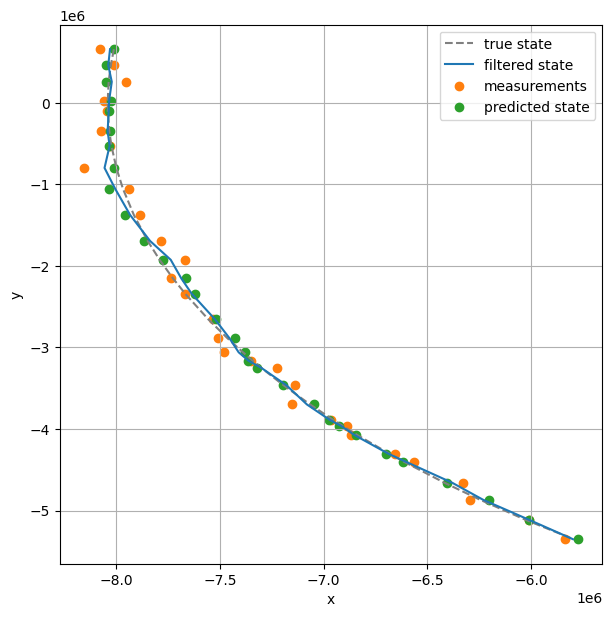

In [550]:
plt.figure(figsize = (7,7))
# plt.plot(xs_true[:20, 0] , xs_true[:20, 1], '--', color='grey', label = 'true state')
# plt.plot(xs[:20, 0] , xs[:20, 1], '-o', color='C0', label = 'filtered state')
# plt.scatter(zs[:20, 0], zs[:20, 1], color = 'C1', label='measurements')
# plt.scatter(xs_prior[:20, 0], xs_prior[:20, 1], color = 'C2', label='predicted state')

plt.plot(xs_true[:30, 0] , xs_true[:30, 1], '--', color='grey', label = 'true state')
plt.plot(xs[:30, 0] , xs[:30, 1],  color='C0', label = 'filtered state')
plt.scatter(zs[:30, 0], zs[:30, 1], color = 'C1', label='measurements')
plt.scatter(xs_prior[:30, 0], xs_prior[:30, 1], color = 'C2', label='predicted state')

# plt.plot(xs_true[-50:, 0] , xs_true[-50:, 1], '--', color='grey', label = 'true state')
# plt.plot(xs[-50:, 0] , xs[-50:, 1],  color='C3', label = 'filtered state')
# plt.scatter(zs[-50:, 0], zs[-50:, 1], color = 'C4', label='measurements')
# plt.scatter(xs_prior[-50:, 0], xs_prior[-50:, 1], color = 'C5', label='predicted state')

plt.xlabel('x')
plt.ylabel('y')
plt.title('')
plt.legend()
plt.grid()
plt.show()

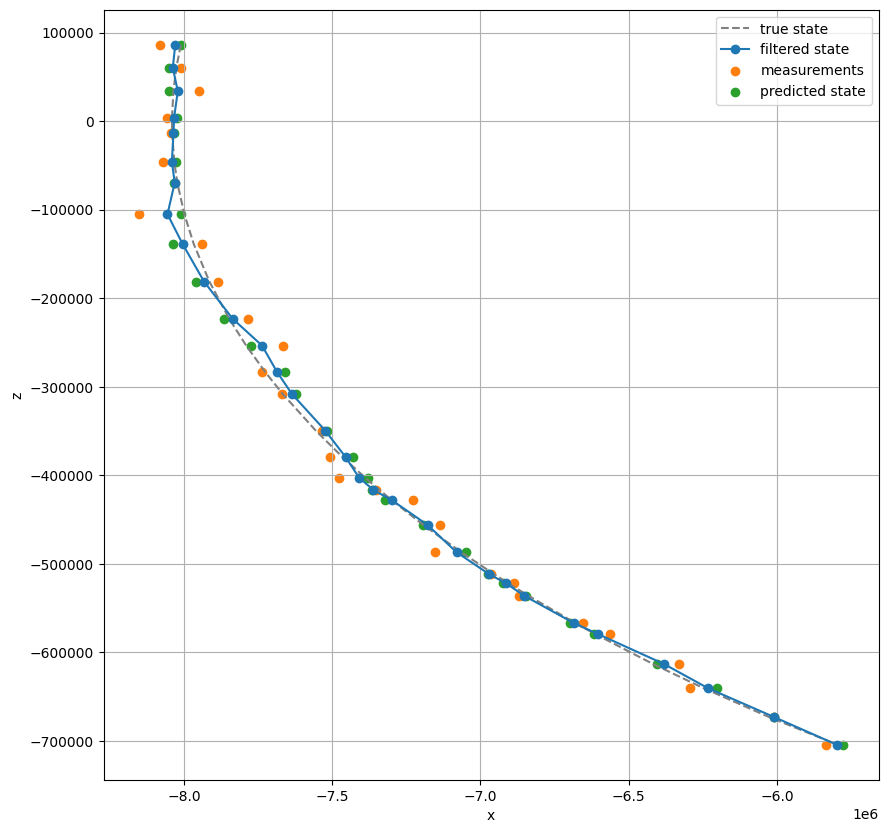

In [546]:
plt.figure(figsize = (10,10))

plt.plot(xs_true[:30, 0] , xs_true[:30, 2], '--', color='grey', label = 'true state')
plt.plot(xs[:30, 0] , xs[:30, 2], '-o', color='C0', label = 'filtered state')
plt.scatter(zs[:30, 0], zs[:30, 2], color = 'C1', label='measurements')
plt.scatter(xs_prior[:30, 0], xs_prior[:30, 2], color = 'C2', label='predicted state')
plt.xlabel('x')
plt.ylabel('z')
plt.title('')
plt.legend()
plt.grid()
plt.show()

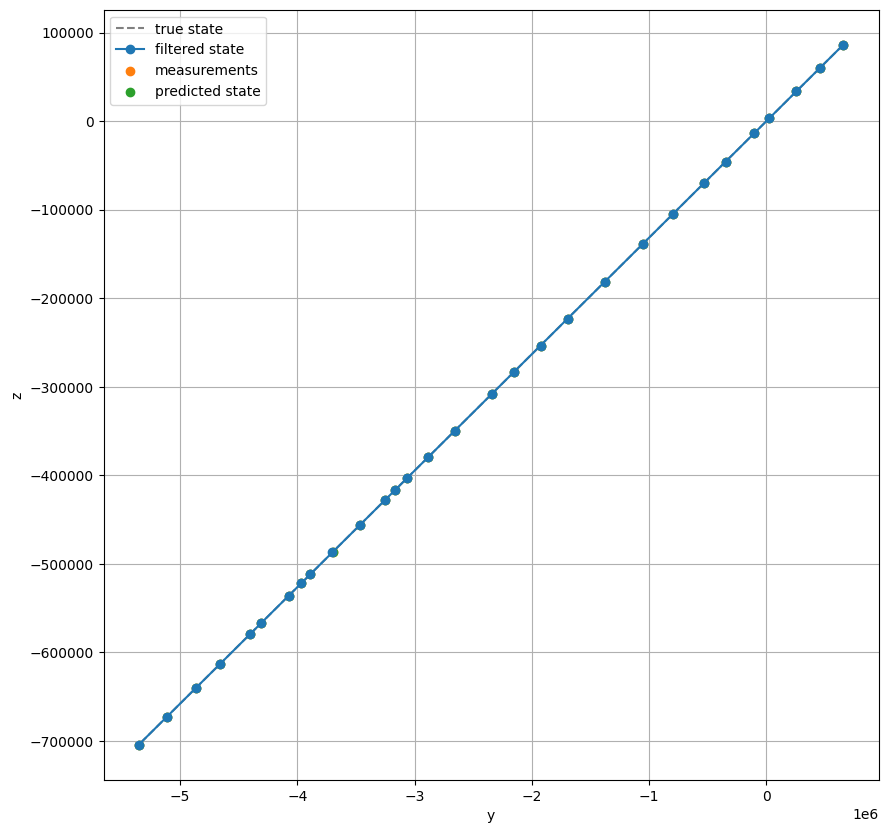

In [547]:
plt.figure(figsize = (10,10))

plt.plot(xs_true[:30, 1] , xs_true[:30, 2], '--', color='grey', label = 'true state')
plt.plot(xs[:30, 1] , xs[:30, 2], '-o', color='C0', label = 'filtered state')
plt.scatter(zs[:30, 1], zs[:30, 2], color = 'C1', label='measurements')
plt.scatter(xs_prior[:30, 1], xs_prior[:30, 2], color = 'C2', label='predicted state')
plt.xlabel('y')
plt.ylabel('z')
plt.title('')
plt.legend()
plt.grid()
plt.show()

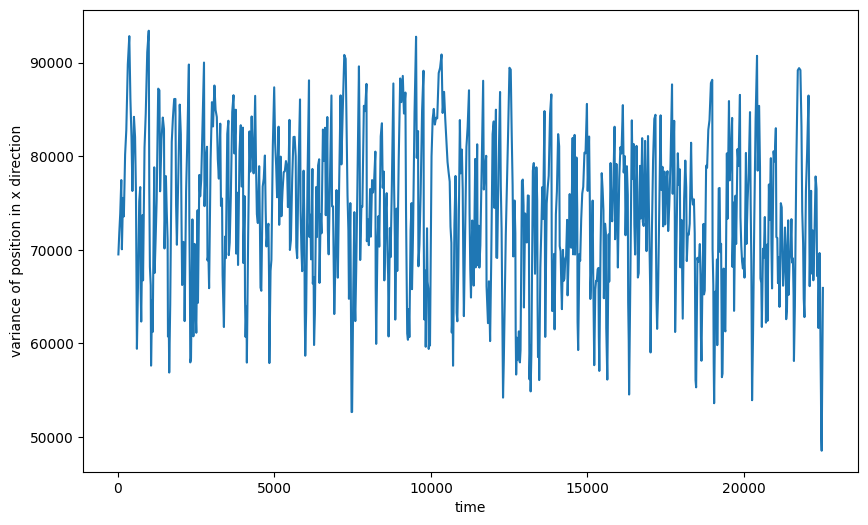

In [551]:
plt.figure(figsize = (10,6))
plt.plot(ts[1:] , Ps[:, 0, 0], label = '')
plt.xlabel('time')
plt.ylabel('variance of position in x direction')
plt.title('')
# plt.legend()
# plt.grid()
plt.show()

